In [1]:
import pandas as pd
import json
import numpy as np
from IPython.display import Markdown,HTML
from copy import deepcopy

In [2]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
def load_json(path):
    with open(path, 'r') as f:
        return json.load(f)

## Load Stuff

In [4]:
raw_data = load_json('data_v2.json')

In [5]:
raw_data.keys()

dict_keys(['source', 'belts', 'pipes', 'buildings', 'miners', 'items', 'fluids', 'recipes', 'resources'])

In [6]:
key_name_fn = lambda x: x.lower().replace(' ', '-')

In [7]:
building_df = pd.DataFrame(raw_data['buildings'])

In [8]:
item_df = pd.DataFrame.from_dict(raw_data['items'])

In [9]:
fluid_df = pd.DataFrame.from_dict(raw_data['fluids'])

In [10]:
resource_df = pd.DataFrame.from_dict(raw_data['resources'])

In [11]:
recipe_df = pd.DataFrame.from_dict(raw_data['recipes'])

## Process recipe data

### Add power info

In [12]:
recipe_category_to_power = building_df.set_index('category')['power'].astype(float).to_dict()
# average of fluctuating
recipe_category_to_power.update({'converting' : 250, 'encoding' : 1000})
recipe_df['power_rate'] = recipe_df['category'].map(recipe_category_to_power)

In [13]:
recipe_df.loc[recipe_df['category'] == 'accelerating', 'power_rate'] = recipe_df.loc[recipe_df['category'] == 'accelerating', 'power_range'].apply(lambda x: 1/2 * (x[0] + x[1]))

### Recipes for Base items - e.g. ore

In [14]:
base_items_info = {
    'miners' : {
        'Iron Ore' : {'impure' : 39, 'normal' : 42, 'pure' : 46},
        'Limestone': {'impure' : 15, 'normal' : 50, 'pure' : 29},
        'Copper Ore': {'impure' : 13, 'normal' : 29, 'pure' : 13},
        'Bauxite': {'impure' : 5, 'normal' : 6, 'pure' : 6},
        'Caterium Ore': {'impure' : 0, 'normal' : 9, 'pure' : 8},
        'Coal': {'impure' : 15, 'normal' : 31, 'pure' : 16},
        'Raw Quartz': {'impure' : 3, 'normal' : 7, 'pure' : 7},
        'Sulfur': {'impure' : 6, 'normal' : 5, 'pure' : 5},
        'Uranium': {'impure' : 3, 'normal' : 2, 'pure' : 0},
        'SAM': {'impure' : 10, 'normal' : 6, 'pure' : 3},
    },
    'oil-extractors' : {
        'Crude Oil': {'impure' : 10, 'normal' : 12, 'pure' : 8},
    },
    'well-extractors' : {
        'Crude Oil' : {'impure' : 8, 'normal' : 6, 'pure' : 4},
        'Nitrogen Gas': {'impure' : 39, 'normal' : 42, 'pure' : 46},
    }
}

In [15]:
## HANDLE WATER & SOMERSLOOP SEPERATELY!!!!

In [16]:
base_rows = [
    ['Water', 'water', 'base', 1, [], [['water', 120]], np.nan, 20],
    ['Somersloop', 'somersloop', 'base', 1, [], [['somersloop', 1]], np.nan, 0]
]
base_resource_constraints = {
    'water' : 1_312_500,
    'somersloop' : 106
}

In [17]:
scale_dict = {'impure' : 1, 'normal' : 2, 'pure' : 4}
power_dict = {'miners' : 5, 'oil-extractors': 40, 'well-extractors' : 0}
extraction_speeds = {'miners' : {'impure' : 120, 'normal' : 240, 'pure' : 480}, 'oil-extractors' : {'impure' : 60, 'normal' : 120, 'pure' : 240}, 'well-extractors' : {'impure' : 30, 'normal' : 60, 'pure' : 120}}
for resource_creation_type, resource_dict in base_items_info.items():
    for resource_name, resource_sources in resource_dict.items():
        for resource_source, source_quantity in resource_sources.items():
            this_name = f'{resource_name} {resource_source} {resource_creation_type}'
            this_name_key = key_name_fn(this_name)
            
            base_resource_constraints[this_name_key] = source_quantity
            base_rows.append([
                this_name, this_name_key, 'base', 60, [], [[key_name_fn(resource_name), extraction_speeds[resource_creation_type][resource_source]]], np.nan,  power_dict[resource_creation_type]
            ])
    

In [18]:
base_recipes = pd.DataFrame(base_rows, columns = list(recipe_df))

In [19]:
base_recipes

,name,key_name,category,time,ingredients,products,power_range,power_rate
0,Water,water,base,1,[],"[[water, 120]]",NaN,20
1,Somersloop,somersloop,base,1,[],"[[somersloop, 1]]",NaN,0
2,Iron Ore impure miners,iron-ore-impure-miners,base,60,[],"[[iron-ore, 120]]",NaN,5
3,Iron Ore normal miners,iron-ore-normal-miners,base,60,[],"[[iron-ore, 240]]",NaN,5
4,Iron Ore pure miners,iron-ore-pure-miners,base,60,[],"[[iron-ore, 480]]",NaN,5
5,Limestone impure miners,limestone-impure-miners,base,60,[],"[[limestone, 120]]",NaN,5
6,Limestone normal miners,limestone-normal-miners,base,60,[],"[[limestone, 240]]",NaN,5
7,Limestone pure miners,limestone-pure-miners,base,60,[],"[[limestone, 480]]",NaN,5
8,Copper Ore impure miners,copper-ore-impure-miners,base,60,[],"[[copper-ore, 120]]",NaN,5
9,Copper Ore normal miners,copper-ore-normal-miners,base,60,[],"[[copper-ore, 240]]",NaN,5


In [20]:
# Geothermal vents = +7100
# Assume all resource wells are overclocked: 9 wells @ 503 each
MAP_FREE_POWER = 7100 - 503.66 * 9

In [21]:
MAP_FREE_POWER

2567.0599999999995

In [22]:
base_recipes.sort_values('key_name')

,name,key_name,category,time,ingredients,products,power_range,power_rate
11,Bauxite impure miners,bauxite-impure-miners,base,60,[],"[[bauxite, 120]]",NaN,5
12,Bauxite normal miners,bauxite-normal-miners,base,60,[],"[[bauxite, 240]]",NaN,5
13,Bauxite pure miners,bauxite-pure-miners,base,60,[],"[[bauxite, 480]]",NaN,5
14,Caterium Ore impure miners,caterium-ore-impure-miners,base,60,[],"[[caterium-ore, 120]]",NaN,5
15,Caterium Ore normal miners,caterium-ore-normal-miners,base,60,[],"[[caterium-ore, 240]]",NaN,5
16,Caterium Ore pure miners,caterium-ore-pure-miners,base,60,[],"[[caterium-ore, 480]]",NaN,5
17,Coal impure miners,coal-impure-miners,base,60,[],"[[coal, 120]]",NaN,5
18,Coal normal miners,coal-normal-miners,base,60,[],"[[coal, 240]]",NaN,5
19,Coal pure miners,coal-pure-miners,base,60,[],"[[coal, 480]]",NaN,5
8,Copper Ore impure miners,copper-ore-impure-miners,base,60,[],"[[copper-ore, 120]]",NaN,5


In [23]:
len(base_recipes), len(base_resource_constraints)

(41, 41)

In [24]:
# base_items = ['Iron Ore', 'Limestone', 'Copper Ore', 'Bauxite', 'Caterium Ore', 'Coal','Raw Quartz', 'Sulfur', 'Uranium'] + ['Nitrogen Gas', 'Water', 'Crude Oil', 'SAM', 'Somersloop']
# base_key_items = [key_name_fn(x) for x in base_items]
# base_key_items_set = set(base_key_items)

In [25]:
# base_recipes = pd.DataFrame([[it, key_it, 'base', 1/1200 if not key_it in {'water', 'crude-oil', 'nitrogen-gas'} else 1/600, [], [[key_it, 1]], np.nan, 0] for (it, key_it) in zip(base_items, base_key_items)], columns = list(recipe_df))
# base_recipes.shape

In [26]:
# base_recipes.loc[base_recipes['key_name'] == 'somersloop', 'time'] = 1

In [27]:
# base_recipes['power_rate'] = [45, 45, 45, 45, 45, 45, 45, 45, 45, 150, 20, 40, 45, 0]

In [28]:
recipe_df = pd.concat([recipe_df, base_recipes])

In [29]:
# base_recipes

### Power Reecipes

In [30]:
# items per minute
power_recipes = pd.DataFrame([
                                ['coal-coal-power', [['coal', 15], ['water', 45]], [], -75],
                                ['coal-compacted-coal-power', [['compacted-coal', 7 + 1/7], ['water', 45]], [], -75],
                                ['coal-petroleum-coke-power', [['petroleum-coke', 25], ['water', 45]], [], -75],
    
                                ['fuel-powered-fuel-power', [['fuel', 20]], [], -250],
                                ['fuel-powered-liquid-biofuel-power', [['liquid-biofuel', 20]],[], -250],
                                ['fuel-powered-turbofuel-power', [['turbofuel', 7.5]], [], -250],
                                ['fuel-powered-rocket-fuel-power', [['rocket-fuel', 4 + 1/6]], [], -250],
                                ['fuel-powered-ionized-fuel-power', [['ionized-fuel', 3]], [], -250],
                                ['nuclear-uranium-power', [['water', 240], ['uranium-fuel-rod', .3]], [['uranium-waste', 10]], -2500],
                                ['nuclear-plutonium-power', [['water', 240], ['plutonium-fuel-rod', .1]], [['plutonium-waste', 1]], -2500],
                                ['nuclear-ficsonium-power', [['water', 240], ['ficsonium-fuel-rod', 1]], [], -2500],
                             ],columns = ['key_name', 'ingredients', 'products', 'power_rate'])
power_recipes['name'] = power_recipes['key_name']
power_recipes['category'] = 'power'
power_recipes['power_range'] = np.nan
power_recipes['time'] = 60

In [31]:
power_recipes

,key_name,ingredients,products,power_rate,name,category,power_range,time
0,coal-coal-power,"[[coal, 15], [water, 45]]",[],-75,coal-coal-power,power,NaN,60
1,coal-compacted-coal-power,"[[compacted-coal, 7.142857142857143], [water, ...",[],-75,coal-compacted-coal-power,power,NaN,60
2,coal-petroleum-coke-power,"[[petroleum-coke, 25], [water, 45]]",[],-75,coal-petroleum-coke-power,power,NaN,60
3,fuel-powered-fuel-power,"[[fuel, 20]]",[],-250,fuel-powered-fuel-power,power,NaN,60
4,fuel-powered-liquid-biofuel-power,"[[liquid-biofuel, 20]]",[],-250,fuel-powered-liquid-biofuel-power,power,NaN,60
5,fuel-powered-turbofuel-power,"[[turbofuel, 7.5]]",[],-250,fuel-powered-turbofuel-power,power,NaN,60
6,fuel-powered-rocket-fuel-power,"[[rocket-fuel, 4.166666666666667]]",[],-250,fuel-powered-rocket-fuel-power,power,NaN,60
7,fuel-powered-ionized-fuel-power,"[[ionized-fuel, 3]]",[],-250,fuel-powered-ionized-fuel-power,power,NaN,60
8,nuclear-uranium-power,"[[water, 240], [uranium-fuel-rod, 0.3]]","[[uranium-waste, 10]]",-2500,nuclear-uranium-power,power,NaN,60
9,nuclear-plutonium-power,"[[water, 240], [plutonium-fuel-rod, 0.1]]","[[plutonium-waste, 1]]",-2500,nuclear-plutonium-power,power,NaN,60


In [32]:
recipe_df.shape, power_recipes.shape

((313, 8), (11, 8))

In [33]:
recipe_df = pd.concat([recipe_df, power_recipes], axis=0)

In [34]:
recipe_df

,name,key_name,category,time,ingredients,products,power_range,power_rate
0,Iron Ingot,iron-ingot,smelting1,2.0,"[[iron-ore, 1]]","[[iron-ingot, 1]]",NaN,4.0
1,Alternate: Iron Alloy Ingot,alt-iron-ingot,smelting2,12.0,"[[iron-ore, 8], [copper-ore, 2]]","[[iron-ingot, 15]]",NaN,16.0
2,Alternate: Pure Iron Ingot,alt-pure-iron-ingot,refining,12.0,"[[iron-ore, 7], [water, 4]]","[[iron-ingot, 13]]",NaN,30.0
3,Alternate: Leached Iron Ingot,alt-leached-iron-ingot,refining,6.0,"[[iron-ore, 5], [sulfuric-acid, 1]]","[[iron-ingot, 10]]",NaN,30.0
4,Copper Ingot,copper-ingot,smelting1,2.0,"[[copper-ore, 1]]","[[copper-ingot, 1]]",NaN,4.0
...,...,...,...,...,...,...,...,...
6,fuel-powered-rocket-fuel-power,fuel-powered-rocket-fuel-power,power,60.0,"[[rocket-fuel, 4.166666666666667]]",[],NaN,-250.0
7,fuel-powered-ionized-fuel-power,fuel-powered-ionized-fuel-power,power,60.0,"[[ionized-fuel, 3]]",[],NaN,-250.0
8,nuclear-uranium-power,nuclear-uranium-power,power,60.0,"[[water, 240], [uranium-fuel-rod, 0.3]]","[[uranium-waste, 10]]",NaN,-2500.0
9,nuclear-plutonium-power,nuclear-plutonium-power,power,60.0,"[[water, 240], [plutonium-fuel-rod, 0.1]]","[[plutonium-waste, 1]]",NaN,-2500.0


### Add Recipes for poower slugs/sommerslops

In [35]:
slooped_recipes = recipe_df.copy()

In [36]:
nonsloopable = ['base', 'power', 'packaging', 'nuke-reacting']
sloop_costs = {
    'crafting1' : 1,
    'crafting2' : 2,
    'crafting3' : 4,
    'refining' : 2,
    'converting' : 2,
    'blending' : 4,
    'accelerating' : 4,
    'smelting1' : 1,
    'smelting2' : 2,
    'encoding' : 4,
}

In [37]:
slooped_recipes['category'].value_counts(dropna=False)

category
crafting2        60
crafting1        43
base             41
crafting3        37
refining         34
converting       25
packaging        24
blending         16
accelerating     12
power            11
smelting2         9
encoding          6
smelting1         4
nuke-reacting     2
Name: count, dtype: int64

In [38]:
slooped_recipes = slooped_recipes[~slooped_recipes['category'].isin(nonsloopable)]

In [39]:
slooped_recipes['key_name'] = slooped_recipes['key_name'].apply(lambda x: x + '-slooped')

In [40]:
slooped_recipes['ingredients'] = slooped_recipes.apply(lambda x: x['ingredients'] + [['somersloop', sloop_costs[x['category']]]], axis=1)
slooped_recipes['products'] = slooped_recipes['products'].apply(lambda x: [[y[0], y[1] * 2] for y in x])
slooped_recipes['power_rate'] = slooped_recipes['power_rate'] * 4

In [41]:
slooped_recipes

,name,key_name,category,time,ingredients,products,power_range,power_rate
0,Iron Ingot,iron-ingot-slooped,smelting1,2.0,"[[iron-ore, 1], [somersloop, 1]]","[[iron-ingot, 2]]",NaN,16.0
1,Alternate: Iron Alloy Ingot,alt-iron-ingot-slooped,smelting2,12.0,"[[iron-ore, 8], [copper-ore, 2], [somersloop, 2]]","[[iron-ingot, 30]]",NaN,64.0
2,Alternate: Pure Iron Ingot,alt-pure-iron-ingot-slooped,refining,12.0,"[[iron-ore, 7], [water, 4], [somersloop, 2]]","[[iron-ingot, 26]]",NaN,120.0
3,Alternate: Leached Iron Ingot,alt-leached-iron-ingot-slooped,refining,6.0,"[[iron-ore, 5], [sulfuric-acid, 1], [somersloo...","[[iron-ingot, 20]]",NaN,120.0
4,Copper Ingot,copper-ingot-slooped,smelting1,2.0,"[[copper-ore, 1], [somersloop, 1]]","[[copper-ingot, 2]]",NaN,16.0
...,...,...,...,...,...,...,...,...
265,Bauxite (Copper),bauxite-copper-slooped,converting,6.0,"[[reanimated-sam, 1], [copper-ore, 18], [somer...","[[bauxite, 24]]",NaN,1000.0
266,Bauxite (Caterium),bauxite-caterium-slooped,converting,6.0,"[[reanimated-sam, 1], [caterium-ore, 15], [som...","[[bauxite, 24]]",NaN,1000.0
267,Nitrogen Gas (Caterium),nitrogen-gas-caterium-slooped,converting,6.0,"[[reanimated-sam, 1], [caterium-ore, 12], [som...","[[nitrogen-gas, 24]]",NaN,1000.0
268,Nitrogen Gas (Bauxite),nitrogen-gas-bauxite-slooped,converting,6.0,"[[reanimated-sam, 1], [bauxite, 10], [somerslo...","[[nitrogen-gas, 24]]",NaN,1000.0


In [42]:
recipe_df = pd.concat([recipe_df, slooped_recipes])

In [43]:
recipe_df

,name,key_name,category,time,ingredients,products,power_range,power_rate
0,Iron Ingot,iron-ingot,smelting1,2.0,"[[iron-ore, 1]]","[[iron-ingot, 1]]",NaN,4.0
1,Alternate: Iron Alloy Ingot,alt-iron-ingot,smelting2,12.0,"[[iron-ore, 8], [copper-ore, 2]]","[[iron-ingot, 15]]",NaN,16.0
2,Alternate: Pure Iron Ingot,alt-pure-iron-ingot,refining,12.0,"[[iron-ore, 7], [water, 4]]","[[iron-ingot, 13]]",NaN,30.0
3,Alternate: Leached Iron Ingot,alt-leached-iron-ingot,refining,6.0,"[[iron-ore, 5], [sulfuric-acid, 1]]","[[iron-ingot, 10]]",NaN,30.0
4,Copper Ingot,copper-ingot,smelting1,2.0,"[[copper-ore, 1]]","[[copper-ingot, 1]]",NaN,4.0
...,...,...,...,...,...,...,...,...
265,Bauxite (Copper),bauxite-copper-slooped,converting,6.0,"[[reanimated-sam, 1], [copper-ore, 18], [somer...","[[bauxite, 24]]",NaN,1000.0
266,Bauxite (Caterium),bauxite-caterium-slooped,converting,6.0,"[[reanimated-sam, 1], [caterium-ore, 15], [som...","[[bauxite, 24]]",NaN,1000.0
267,Nitrogen Gas (Caterium),nitrogen-gas-caterium-slooped,converting,6.0,"[[reanimated-sam, 1], [caterium-ore, 12], [som...","[[nitrogen-gas, 24]]",NaN,1000.0
268,Nitrogen Gas (Bauxite),nitrogen-gas-bauxite-slooped,converting,6.0,"[[reanimated-sam, 1], [bauxite, 10], [somerslo...","[[nitrogen-gas, 24]]",NaN,1000.0


In [44]:
overclocked = recipe_df.copy()

In [45]:
non_overclockable = {'power-shard', 'somersloop'}
overclocked = overclocked[~(overclocked['key_name'].apply(lambda x: any([bad == x for bad in non_overclockable])))]

In [46]:
overclocked['key_name'] = overclocked['key_name'].apply(lambda x: x + '-overclocked')
overclocked['ingredients'] = overclocked['ingredients'].apply(lambda x: [[y[0], (y[1] * (2.5 if not y[0] in {'somersloop'} else 1))] for y in x])
overclocked['products'] = overclocked['products'].apply(lambda x: [[y[0], (y[1] * (2.5 if not y[1] in {'somersloop'} else 1))] for y in x])
overclocked.loc[overclocked['category'] == 'power', 'power_rate'] *= 2.5
overclocked.loc[~(overclocked['category'] == 'power'), 'power_rate'] *= 2.5**1.321928

In [47]:
overclocked.shape

(569, 8)

In [48]:
overclocked[overclocked['key_name'] == 'iron-ingot-slooped-overclocked']

,name,key_name,category,time,ingredients,products,power_range,power_rate
0,Iron Ingot,iron-ingot-slooped-overclocked,smelting1,2.0,"[[iron-ore, 2.5], [somersloop, 1]]","[[iron-ingot, 5.0]]",NaN,53.723961


In [49]:
overclocked[overclocked['key_name'].apply(lambda x: 'iron-ore' in x)]

,name,key_name,category,time,ingredients,products,power_range,power_rate
253,Iron Ore (Limestone),iron-ore-limestone-overclocked,converting,6.0,"[[reanimated-sam, 2.5], [limestone, 60.0]]","[[iron-ore, 30.0]]",NaN,839.436885
2,Iron Ore impure miners,iron-ore-impure-miners-overclocked,base,60.0,[],"[[iron-ore, 300.0]]",NaN,16.788738
3,Iron Ore normal miners,iron-ore-normal-miners-overclocked,base,60.0,[],"[[iron-ore, 600.0]]",NaN,16.788738
4,Iron Ore pure miners,iron-ore-pure-miners-overclocked,base,60.0,[],"[[iron-ore, 1200.0]]",NaN,16.788738
253,Iron Ore (Limestone),iron-ore-limestone-slooped-overclocked,converting,6.0,"[[reanimated-sam, 2.5], [limestone, 60.0], [so...","[[iron-ore, 60.0]]",NaN,3357.747541


In [50]:
recipe_df = pd.concat([recipe_df, overclocked]).reset_index(drop=True)

### Only use overclocked water because effort
* also add + 16 power = 20 Mk2 headlift pumps

In [51]:
recipe_df[recipe_df['key_name'].apply(lambda x: 'water' in x)]

,name,key_name,category,time,ingredients,products,power_range,power_rate
178,Packaged Water,packaged-water,packaging,2.0,"[[water, 2], [empty-canister, 2]]","[[packaged-water, 2]]",NaN,10.000000
179,Unpackage Water,unpackage-water,packaging,1.0,"[[packaged-water, 2]]","[[water, 2], [empty-canister, 2]]",NaN,10.000000
272,Water,water,base,1.0,[],"[[water, 120]]",NaN,20.000000
748,Packaged Water,packaged-water-overclocked,packaging,2.0,"[[water, 5.0], [empty-canister, 5.0]]","[[packaged-water, 5.0]]",NaN,33.577475
749,Unpackage Water,unpackage-water-overclocked,packaging,1.0,"[[packaged-water, 5.0]]","[[water, 5.0], [empty-canister, 5.0]]",NaN,33.577475
842,Water,water-overclocked,base,1.0,[],"[[water, 300.0]]",NaN,67.154951


In [52]:
recipe_df = recipe_df[~(recipe_df['key_name'] == 'water')].reset_index(drop=True)

In [53]:
recipe_df.loc[recipe_df['key_name'] == 'water-overclocked', 'power_rate'] += 16

### load/process points data

In [54]:
points_df = pd.read_csv('points.csv')

In [55]:
points_df

,Points,Items
0,Cannot be sunk,"Alien Protein, Bacon Agaric, Beryl Nut, Bl..."
1,1,"Blue FICSMAS Ornament, FICSIT Coupon, FICSM..."
2,2,"FICSMAS Tree Branch, Iron Ingot, Limestone,..."
3,3,"Coal, Copper Ore, Leaves"
4,4,"FICSMAS Bow, Iron Rod"
...,...,...
120,"500,176",Assembly Director System
121,"538,976",Nuclear Pasta
122,"597,652",AI Expansion Server
123,"728,508",Thermal Propulsion Rocket


In [56]:
list(points_df)

['Points ', 'Items']

In [57]:
# split stuff as list by comma & explode
points_df = points_df.iloc[1:].copy()
points_df['Items'] = points_df['Items'].apply(lambda x: x.split(','))
points_df = points_df.explode('Items').reset_index(drop=True)
points_df.rename({'Points ' : 'points', 'Items' : 'item'}, axis=1, inplace=True)
points_df = points_df[points_df['points'] != 'Cannot be sunk ']
points_df['item'] = points_df['item'].apply(lambda x: x.strip())
points_df['points'] = points_df['points'].apply(lambda x: int(x.replace(',', '')))

In [58]:
points_df

,points,item
0,1,Blue FICSMAS Ornament
1,1,FICSIT Coupon
2,1,FICSMAS Gift
3,1,Iron Ore
4,2,FICSMAS Tree Branch
...,...,...
152,500176,Assembly Director System
153,538976,Nuclear Pasta
154,597652,AI Expansion Server
155,728508,Thermal Propulsion Rocket


In [59]:
# points_df[points_df['item'] == 'SAM Fluctuator']

In [60]:
garbage = ["Actual Snow",
"Candy Cane",
"FICSMAS Gift",
"Sweet Fireworks",
"Sparkly Fireworks",
"Copper FICSMAS Ornament",
"FICSMAS Ornament Bundle",
"Iron FICSMAS Ornament",
"Snowball",
"Red FICSMAS Ornament",
"FICSMAS Wonder Star",
"Fancy Fireworks",
"FICSMAS Bow",
'Portable Miner']

In [61]:
points_df = points_df[points_df['item'].apply(lambda x: not x in garbage)].reset_index(drop=True)

In [62]:
points_df['key_name'] = points_df['item'].apply(key_name_fn)

In [63]:
recipe_df

,name,key_name,category,time,ingredients,products,power_range,power_rate
0,Iron Ingot,iron-ingot,smelting1,2.0,"[[iron-ore, 1]]","[[iron-ingot, 1]]",NaN,4.000000
1,Alternate: Iron Alloy Ingot,alt-iron-ingot,smelting2,12.0,"[[iron-ore, 8], [copper-ore, 2]]","[[iron-ingot, 15]]",NaN,16.000000
2,Alternate: Pure Iron Ingot,alt-pure-iron-ingot,refining,12.0,"[[iron-ore, 7], [water, 4]]","[[iron-ingot, 13]]",NaN,30.000000
3,Alternate: Leached Iron Ingot,alt-leached-iron-ingot,refining,6.0,"[[iron-ore, 5], [sulfuric-acid, 1]]","[[iron-ingot, 10]]",NaN,30.000000
4,Copper Ingot,copper-ingot,smelting1,2.0,"[[copper-ore, 1]]","[[copper-ingot, 1]]",NaN,4.000000
...,...,...,...,...,...,...,...,...
1133,Bauxite (Copper),bauxite-copper-slooped-overclocked,converting,6.0,"[[reanimated-sam, 2.5], [copper-ore, 45.0], [s...","[[bauxite, 60.0]]",NaN,3357.747541
1134,Bauxite (Caterium),bauxite-caterium-slooped-overclocked,converting,6.0,"[[reanimated-sam, 2.5], [caterium-ore, 37.5], ...","[[bauxite, 60.0]]",NaN,3357.747541
1135,Nitrogen Gas (Caterium),nitrogen-gas-caterium-slooped-overclocked,converting,6.0,"[[reanimated-sam, 2.5], [caterium-ore, 30.0], ...","[[nitrogen-gas, 60.0]]",NaN,3357.747541
1136,Nitrogen Gas (Bauxite),nitrogen-gas-bauxite-slooped-overclocked,converting,6.0,"[[reanimated-sam, 2.5], [bauxite, 25.0], [some...","[[nitrogen-gas, 60.0]]",NaN,3357.747541


In [64]:
points_df

,points,item,key_name
0,1,Blue FICSMAS Ornament,blue-ficsmas-ornament
1,1,FICSIT Coupon,ficsit-coupon
2,1,Iron Ore,iron-ore
3,2,FICSMAS Tree Branch,ficsmas-tree-branch
4,2,Iron Ingot,iron-ingot
...,...,...,...
138,500176,Assembly Director System,assembly-director-system
139,538976,Nuclear Pasta,nuclear-pasta
140,597652,AI Expansion Server,ai-expansion-server
141,728508,Thermal Propulsion Rocket,thermal-propulsion-rocket


### Filter out unwanted things form poitns & recipes

In [65]:
ignore_things = [key_name_fn(x) for x in ['Hog Remains', 'Spitter Remains', 'Stinger Remains', 'Hatcher Remains', 'Leaves', 'Wood', 'Mycelia', 'Yellow Power Slug', 'Purple Power Slug', 'Blue Power Slug', 'Automated Miner', 'Portable Miner', 'Alien DNA Capsule']]
ignore_things = ignore_things + [x + '-slooped' for x in ignore_things]

In [66]:
print(recipe_df.shape)
recipe_df = recipe_df[recipe_df['products'].apply(lambda x: not any([y[0] in ignore_things for y in x]))].reset_index(drop=True)
recipe_df = recipe_df[recipe_df['ingredients'].apply(lambda x: not any([y[0] in ignore_things for y in x]))].reset_index(drop=True)
recipe_df = recipe_df[~recipe_df['key_name'].isin(ignore_things)].reset_index(drop=True)
recipe_df.shape

(1138, 8)


(1082, 8)

In [67]:
recipe_df[recipe_df['key_name'].apply(lambda x: 'power-shard' in x)]

,name,key_name,category,time,ingredients,products,power_range,power_rate
232,Synthetic Power Shard,synthetic-power-shard,encoding,12.0,"[[time-crystal, 2], [dark-matter-crystal, 2], ...","[[power-shard, 1], [dark-matter-residue, 12]]",NaN,1000.000000
517,Synthetic Power Shard,synthetic-power-shard-slooped,encoding,12.0,"[[time-crystal, 2], [dark-matter-crystal, 2], ...","[[power-shard, 2], [dark-matter-residue, 24]]",NaN,4000.000000
773,Synthetic Power Shard,synthetic-power-shard-overclocked,encoding,12.0,"[[time-crystal, 5.0], [dark-matter-crystal, 5....","[[power-shard, 2.5], [dark-matter-residue, 30.0]]",NaN,3357.747541
1058,Synthetic Power Shard,synthetic-power-shard-slooped-overclocked,encoding,12.0,"[[time-crystal, 5.0], [dark-matter-crystal, 5....","[[power-shard, 5.0], [dark-matter-residue, 60.0]]",NaN,13430.990166


In [68]:
print(points_df.shape)
points_df = points_df[~points_df['key_name'].isin(ignore_things)].reset_index(drop=True)
points_df.shape

(143, 3)


(140, 3)

### Make points data & recipe data joinable

In [69]:
points_rename_mapper = {
    'encased-uranium-cell' : 'uranium-cell',
#     'biomass-(leaves)' : 'biomass-from-leaves',
#     'biomass-(mycelia)' : 'biomass-from-mycelia',
#     'biomass-(wood)' : 'biomass-from-wood',
    'gas-filter' : 'filter',
    'electromagnetic-control-rod' : 'em-control-rod',
    
}
points_df['key_name'] = points_df['key_name'].apply(lambda x: points_rename_mapper.get(x, x))

### Validate that everything is good
We need:  
* all ingredients/products that should be scoreable are scoreable
* WHAT ELSE DO WE NEED???

In [70]:
NO_SINK_ENTRY = set([key_name_fn(x) for x in ['Alien Protein', 'Encased Plutonium Cell', 'Ficsonium', 'Ficsonium Fuel Rod', 'Non Fissile Uranium', 'Plutonium Pellet', 'Plutonium Waste', 'Power Shard', 'Uranium Waste', 'Somersloop']] + fluid_df['key_name'].tolist())

In [71]:
all_ingredients = set(recipe_df['ingredients'].explode().dropna().apply(lambda x: x[0] if len(x) else None).dropna().unique())
all_products = set(recipe_df['products'].explode().dropna().apply(lambda x: x[0] if len(x) else None).dropna().unique())

In [72]:
all_scoreables = set(points_df['key_name'].tolist())

In [73]:
len(all_ingredients), len(all_products), len(all_scoreables)

(126, 139, 140)

In [74]:
missing_scores = (all_ingredients | all_products) - all_scoreables - NO_SINK_ENTRY

In [75]:
if len(missing_scores):
    print('MISSING: ', missing_scores)
    raise ValueError

In [76]:
recipe_df[recipe_df['key_name'].apply(lambda x: 'power-shard' in x)]

,name,key_name,category,time,ingredients,products,power_range,power_rate
232,Synthetic Power Shard,synthetic-power-shard,encoding,12.0,"[[time-crystal, 2], [dark-matter-crystal, 2], ...","[[power-shard, 1], [dark-matter-residue, 12]]",NaN,1000.000000
517,Synthetic Power Shard,synthetic-power-shard-slooped,encoding,12.0,"[[time-crystal, 2], [dark-matter-crystal, 2], ...","[[power-shard, 2], [dark-matter-residue, 24]]",NaN,4000.000000
773,Synthetic Power Shard,synthetic-power-shard-overclocked,encoding,12.0,"[[time-crystal, 5.0], [dark-matter-crystal, 5....","[[power-shard, 2.5], [dark-matter-residue, 30.0]]",NaN,3357.747541
1058,Synthetic Power Shard,synthetic-power-shard-slooped-overclocked,encoding,12.0,"[[time-crystal, 5.0], [dark-matter-crystal, 5....","[[power-shard, 5.0], [dark-matter-residue, 60.0]]",NaN,13430.990166


In [77]:
# sys.exit()

### Setup/Solve LP!

In [78]:
"""
how on earth do I make a linear program again???

scipy API:
    params: A_ub, b_ub, A_eq, b_eq, (lb, ub)
    integrality: [0,3]; each int is method of considering problem; 3:= integers & 0 acceptable

    min c.T @ X
    s.t.
    A_{ub}x <= b_{ub}
    A_{eq}x == b_{eq}
    lb <= x <= ub


X: baseline: how many of each item am I making
C: associated score

Issue:
    items get used as ingredients don't get scored, but you'd want to use them potentially
    So need to duplicate all items:
        [items1, items2]
        items

"""


"\nhow on earth do I make a linear program again???\n\nscipy API:\n    params: A_ub, b_ub, A_eq, b_eq, (lb, ub)\n    integrality: [0,3]; each int is method of considering problem; 3:= integers & 0 acceptable\n\n    min c.T @ X\n    s.t.\n    A_{ub}x <= b_{ub}\n    A_{eq}x == b_{eq}\n    lb <= x <= ub\n\n\nX: baseline: how many of each item am I making\nC: associated score\n\nIssue:\n    items get used as ingredients don't get scored, but you'd want to use them potentially\n    So need to duplicate all items:\n        [items1, items2]\n        items\n\n"

In [79]:
base_resource_constraints

{'water': 1312500,
 'somersloop': 106,
 'iron-ore-impure-miners': 39,
 'iron-ore-normal-miners': 42,
 'iron-ore-pure-miners': 46,
 'limestone-impure-miners': 15,
 'limestone-normal-miners': 50,
 'limestone-pure-miners': 29,
 'copper-ore-impure-miners': 13,
 'copper-ore-normal-miners': 29,
 'copper-ore-pure-miners': 13,
 'bauxite-impure-miners': 5,
 'bauxite-normal-miners': 6,
 'bauxite-pure-miners': 6,
 'caterium-ore-impure-miners': 0,
 'caterium-ore-normal-miners': 9,
 'caterium-ore-pure-miners': 8,
 'coal-impure-miners': 15,
 'coal-normal-miners': 31,
 'coal-pure-miners': 16,
 'raw-quartz-impure-miners': 3,
 'raw-quartz-normal-miners': 7,
 'raw-quartz-pure-miners': 7,
 'sulfur-impure-miners': 6,
 'sulfur-normal-miners': 5,
 'sulfur-pure-miners': 5,
 'uranium-impure-miners': 3,
 'uranium-normal-miners': 2,
 'uranium-pure-miners': 0,
 'sam-impure-miners': 10,
 'sam-normal-miners': 6,
 'sam-pure-miners': 3,
 'crude-oil-impure-oil-extractors': 10,
 'crude-oil-normal-oil-extractors': 12,


In [80]:
base_inputs_test = {'water': 1000,
 'somersloop': 106,
 'iron-ore-impure-miners': 0,
 'iron-ore-normal-miners': 0,
 'iron-ore-pure-miners': 1,
 'coal-impure-miners': 0,
 'coal-normal-miners': 0,
 'coal-pure-miners': 1}
# base_inputs_test = {k : v for k, v in base_resource_constraints.items() if any([x in k for x in ['iron-ore', 'coal', 'water', 'somersloop']])}
# base_inputs_irl = {
#     'coal' : 42300,
#     'crude-oil' : 12600,
#     'nitrogen-gas' : 12000,
#     'bauxite' : 12300,
#     'copper-ore': 36900,
#     'caterium-ore' : 15000,
#     'iron-ore' : 92100,
#     'uranium' : 2100,
#     'raw-quartz' : 13500,
#     'sam' : 10200,
#     'limestone' : 69300,
#     'sulfur' : 10800,
#     'water' : 1312500,
#     'excited-photonic-matter' : 10000,
#     'somersloop' : 106,
# #     'power-shard' : 20_000_000
# }

# for key in base_items:
#     key = key.lower().replace(' ', '-')
#     if key in base_inputs_irl:
#         continue
#     base_inputs_irl[key] = 0


# base_inputs_irl = base_inputs_irl | {x_processed : 0 for x in base_items if (not (x_processed:=x.lower().replace(' ', '-'))) in base_inputs_irl}

In [81]:
import graphviz
def graph_recipes(result_df, min_produced = 1):
    result_df = result_df.copy()
    
    result_df = result_df[(result_df['qty_produce'] >= min_produced) | (result_df['score_output'] > 0)]
    scoring = result_df[result_df['score_output'] > 0]
    

    get_items = lambda x: [y[0] for y in x]
    
    scoring_items = set(scoring['ingredients'].apply(get_items).explode().dropna().unique().tolist())
    
    all_items = sorted(list(set(result_df['ingredients'].apply(get_items).explode().dropna().unique().tolist() + result_df['products'].apply(get_items).explode().dropna().unique().tolist())), key = lambda x: (x not in scoring_items, x))
    
    def shorten_name(name):
        processed = False
        if name.endswith('-slooped-overclocked'):
            name = f'{name[:-20]}\nSO'
            processed = True
        if name.endswith('-overclocked'):
            name = f'{name[:-12]}\nO'
            processed = True
        if name.endswith('-slooped'):
            name = f'{name[:-8]}\nS'
            processed = True
        if not processed:
            name = f'{name}\nX'
        return name
    
    item_graph = graphviz.Digraph('items')
    item_graph.node('sink', 'SINK')
    item_graph.node('source', 'SOURCE')
    for item in all_items:
        item_graph.node(item, item, color = 'blue', fontcolor='blue')
    

    def connect_items(recipe_row):
        if 'trash' in recipe_row['key_name']:
            assert len(recipe_row['ingredients'])==1
            trashed_item = recipe_row['ingredients'][0][0]
            item_graph.edge(trashed_item, 'sink', label = f"{recipe_row['qty_produce']}\n({recipe_row["score_output"]} pts)")
        else:
            color = '#' + ''.join(np.random.choice(['0','1','2','3','4','5','6','7','8','9','A','B','C','D','E'], 6)) + 'EE'
            ingredients = get_items(recipe_row['ingredients'])
            if not len(ingredients) and recipe_row['category'] == 'base':
                ingredients = ['source']
            for ingredient in ingredients:
                for product in get_items(recipe_row['products']):
                    item_graph.edge(ingredient, product, label=shorten_name(recipe_row['key_name']) + f',({recipe_row["qty_produce"]})', color=color, fontcolor=color)
                
                
    result_df.apply(connect_items, axis=1)
#     display(Markdown('## GREEN is Recipe, BLUE is item'))
#     display(Markdown('## O = Overclocked; S = Slooped; SO = Slooped & Overclocked; X = Normal;'))
    display(item_graph)
    
    item_graph.render(filename='chaos.pdf')
    
    

In [82]:
base_inputs_test

{'water': 1000,
 'somersloop': 106,
 'iron-ore-impure-miners': 0,
 'iron-ore-normal-miners': 0,
 'iron-ore-pure-miners': 1,
 'coal-impure-miners': 0,
 'coal-normal-miners': 0,
 'coal-pure-miners': 1}

In [83]:
from scipy.optimize import linprog

In [84]:
import math

In [85]:
#gpt4o couldn't write this function, but claude could
def style_column(col, logspace=False):
    """
    Style a column with color gradient from red (min) to green (max)
    Args:
        col: pandas Series with numeric values
    Returns:
        List of CSS background-color styles
    """
    # Normalize values between 0 and 1
    if pd.isnull(col).all():
        return [''] * col.shape[0]
    if col.shape[0] == 1:
        r = 0
        g = 255
        return [f'background-color:rgba({r}, {g}, 0, 0.5)']
    if logspace:
        col = col.apply(lambda x: np.log(1 + x))
    min_val = col.min()
    max_val = col.max()
    norm = (col - min_val) / (max_val - min_val)
    
    # Convert to RGB colors (red to green)
    def get_color(value):
        if pd.isnull(value):
            return ''
        r = int(255 * (1 - value))
        g = int(255 * value)
        return f'background-color:rgba({r}, {g}, 0, 0.5)'
    
    return [get_color(x) for x in norm]

In [86]:
def visualize_output(rdf,  sort_by_col):
    display(Markdown('## Output'))
    if sort_by_col == 'all':
        for c in ['qty_produce', 'score_output', 'power_work']:
            display(Markdown(f'#### {c}'))
            display(rdf[rdf[c] != 0].sort_values(c, ascending=False).style.apply(style_column, subset=[c]))
    else:
        display(rdf[rdf[sort_by_col] != 0].sort_values(sort_by_col, ascending=False).style.apply(style_column, subset=[sort_by_col]))

    display(Markdown(f'#### slooped'))
    display(rdf[rdf.apply(lambda x: '-slooped' in x['key_name'] and x['qty_produce'] > 0, axis=1)].sort_values('qty_produce', ascending=False).style.apply(style_column, subset='qty_produce'))

    display(Markdown(f'#### overclocked'))
    display(rdf[rdf.apply(lambda x: '-overclocked' in x['key_name'] and x['qty_produce'] > 0, axis=1)].sort_values('qty_produce', ascending=False).style.apply(style_column, subset='qty_produce'))
    
    display(Markdown(f'#### base items'))
    display(rdf[rdf['category'] == 'base'].sort_values('qty_produce', ascending=False).style.apply(lambda x: ['background-color:rgba(255,0,0,.5)' if y <=0 else 'background-color:rgba(0,255,0,.5)' for y in x], subset='qty_produce'))

        

In [87]:
def lp_solve(pdf, rdf, base_inputs, force_excess_unsinkable_usage = 'all', sort_by_col='all', lp_options = None, ):
    lp_options = lp_options or {}
    # what to sort by fof visualizations
    valid_sort_by_col= ['qty_produce', 'score_output', 'power_work'] # + ['all']
    if not sort_by_col in valid_sort_by_col + ['all']:
        raise ValueError(f'sort by col must be in {valid_sort_by_col} or "all"')
    
    # how to handle resources that aren't scoreable
    # all: all must be consumed; waste: only waste must be consumed; None/'': nothing force to be consumed
    valid_excess_unsinkable = {'all', 'waste', None, ''}
    if not force_excess_unsinkable_usage in valid_excess_unsinkable:
        raise ValueError(f'force_excess_unsinkable_usage must be in {valid_excess_unsinkable} or "all"')
    
    pdf = pdf.copy()
    point_mapper = pdf.set_index('key_name')['points'].to_dict()
    
    rdf = rdf.copy()
    if not rdf['key_name'].nunique() == rdf.shape[0]:
        raise ValueError('"key_name" in rrecipe df assumed to be unique, but its not!!!')
    
    
    # setup stuff for algo
    all_recipe_items = sorted(list(set(rdf['ingredients'].explode().dropna().apply(lambda x: x[0]).tolist() + rdf['products'].explode().dropna().apply(lambda x: x[0]).tolist())))
    all_recipe_items_set = set(all_recipe_items)
    
    base_recipe_df = rdf[rdf['category'] == 'base']
#     base_products = set(base_recipe_df['products'].apply(lambda x: x[0][0]).unique().tolist())
    
#     print(base_products)
    base_products = base_recipe_df['key_name'].unique()
    
    
    base_inputs = {k : base_inputs[k] for k in sorted(base_inputs) if k in base_products}
    
    # Create reicpes for dumping stuff into the sink; only recipes for scorable items
    num_items_with_points = np.sum([item in point_mapper for item in all_recipe_items])
    trash_df = pd.DataFrame.from_records([[f'{item} Trash', f'{item}-trash', 'sink', 1/1200, [[item, 1]], [], np.nan, 30] for item in all_recipe_items if item in point_mapper], columns = list(rdf))
    rdf = pd.concat([rdf, trash_df], axis=0).reset_index(drop=True)    
    rdf['id'] = np.arange(rdf.shape[0])
    
    recipe_to_col_idx = {name : i for i, name in enumerate(rdf['key_name'].tolist())}

    
    
    recipe_constraint_row_order = {ing : i for i, ing in enumerate(all_recipe_items)}
    inv_recipe_constraint_row_order = {ing : i for i, ing in enumerate(all_recipe_items)}
    
    """constraints for recipes; +  1 for power"""
    constraint_matrix = np.zeros((len(all_recipe_items) + 1, rdf.shape[0]))
    constraint_values = np.zeros(len(all_recipe_items) + 1)
    def build_recipe_constraints(row):
        ingr_list = row['ingredients']
        products = row['products']
        col_idx = row['id']
        
        if len(ingr_list):
            for ingr, qty in ingr_list:
                constraint_matrix[recipe_constraint_row_order[ingr], col_idx] = qty
        if len(products):
            for prod, qty in products:
                constraint_matrix[recipe_constraint_row_order[prod], col_idx] = -qty
        
        constraint_matrix[-1, col_idx] = row['power_rate'] * row['time']
        
    rdf.apply(build_recipe_constraints, axis=1)
    
    
    """constraints for raw materials"""
    raw_material_constraints = np.zeros((len(base_inputs), rdf.shape[0]))
    raw_material_constraint_values = np.zeros(len(base_inputs))
    
    for i, (item, amount) in enumerate(base_inputs.items()):
        raw_material_constraints[i, recipe_to_col_idx[item]] = 1
        raw_material_constraint_values[i] = amount
        
        overclocked_item = item + '-overclocked'
        if overclocked_item in recipe_to_col_idx:
            raw_material_constraints[i, recipe_to_col_idx[overclocked_item]] = 1
            
    # Full constraint matrix & values
    constraint_matrix = np.concatenate((constraint_matrix, raw_material_constraints), axis=0)
    constraint_values = np.concatenate((constraint_values, raw_material_constraint_values), axis=0)


    # points for everything
    maximize_vec = np.array([0] *(rdf.shape[0] - num_items_with_points) + [point_mapper[item] for item in all_recipe_items if item in point_mapper])

    # Make dataframe for visulaizing the A/b/c/ matrices in clean form
    constraint_df = pd.DataFrame(np.concatenate((np.concatenate((constraint_matrix, constraint_values[:,np.newaxis]), axis=1), np.concatenate((maximize_vec, [np.nan]))[np.newaxis,:]), axis=0), index = all_recipe_items + ['POWER'] + list(base_inputs.keys()) + ['**POINTS**'], columns = rdf['key_name'].tolist() + ['CONSTRAINT_VALUE'])#.reset_index()
    
    display(Markdown('## Constraints'))
    with pd.option_context('display.max_rows', 100, 'display.max_columns', 100):
        display(constraint_df)
    
    
    
    ### solve linear program
    if force_excess_unsinkable_usage:
        constraint_is_waste = np.zeros(constraint_matrix.shape[0], dtype=bool)
        debugging_matches = []
        # figure out what's waste according to param & should be set to "eq"
        for ing, idx in recipe_constraint_row_order.items():
            if force_excess_unsinkable_usage == 'all':
                if not ing in point_mapper:
                    constraint_is_waste[idx] = True
                    debugging_matches.append(ing)
            elif force_excess_unsinkable_usage == 'waste':
                if 'waste' in ing:
                    constraint_is_waste[idx] = True
                    debugging_matches.append(ing)
                
        #  if things to force eq with found, then do that
        # otherwise run as usual
        if constraint_is_waste.sum():
            print('FOUND WASTE: ', debugging_matches)
            lp_res = linprog(-maximize_vec, A_ub=constraint_matrix[~constraint_is_waste], b_ub=constraint_values[~constraint_is_waste], A_eq=constraint_matrix[constraint_is_waste], b_eq=constraint_values[constraint_is_waste], bounds=(0, None), method='highs', callback=None, options=lp_options, x0=None, integrality=3)
            
        else:
            # otherwise, no equality constraints
            lp_res = linprog(-maximize_vec, A_ub=constraint_matrix, b_ub=constraint_values, A_eq=None, b_eq=None, bounds=(0, None), method='highs', callback=None, options=lp_options, x0=None, integrality=3)
        
        
    else:
        lp_res = linprog(-maximize_vec, A_ub=constraint_matrix, b_ub=constraint_values, A_eq=None, b_eq=None, bounds=(0, None), method='highs', callback=None, options=lp_options, x0=None, integrality=3)
    
    values = lp_res.x
    
    rdf['qty_produce'] = values
    rdf['qty_produce'] = rdf['qty_produce'].astype(int)
    if rdf['qty_produce'].isnull().all():
        display(Markdown('## FAIL'))
        print(lp_res.message)
        return lp_res, rdf
    
    rdf['score_output'] = rdf.apply(lambda x: 0 if not x['key_name'].endswith('-trash') else x['qty_produce'] * point_mapper[x['key_name'][:-6]], axis=1)
    rdf['power_work'] = rdf['qty_produce'] * rdf['power_rate'] * rdf['time']
    
    visualize_output(rdf, sort_by_col)
    
    return lp_res, rdf
    
    
    

In [88]:
lp_options = {'disp' : True, 'threads' : 4, 'time_limit':30}

In [89]:
# recipe_df[recipe_df['key_name'].apply(lambda x: 'coal' in x)]

In [90]:
# recipe_df[recipe_df['category'] == 'power']

In [91]:
eg_stuff = {'iron-ore', 'iron-ingot', 'iron-plate', 'iron-rod', 'coal', 'coal-coal-power'}


eg_points = points_df[points_df['key_name'].isin(eg_stuff)].reset_index(drop=True).copy()
eg_recipes = recipe_df[recipe_df['key_name'].isin(eg_stuff)].reset_index(drop=True).copy()


# eg_points = points_df[points_df['key_name'].isin({'iron-ore', 'iron-ingot', 'iron-plate'})].reset_index(drop=True).copy()
# eg_recipes = recipe_df[recipe_df['key_name'].isin({'iron-ingot', 'iron-plate', 'iron-ore'})].reset_index(drop=True).copy()

# eg_points = points_df[points_df['key_name'].isin({'iron-ore', 'iron-ingot'})].reset_index(drop=True).copy()
# eg_recipes = recipe_df[recipe_df['key_name'].isin({'iron-ingot', 'iron-ore'})].reset_index(drop=True).copy()


eg_stuff = eg_stuff | {x + '-slooped' for x in eg_stuff}
eg_stuff = eg_stuff | {x + '-overclocked' for x in eg_stuff}
eg_ingredients = eg_recipes['ingredients'].apply(lambda x: [y[0] for y in x]).explode().dropna().unique().tolist()

eg_base_recipes = recipe_df[recipe_df['category'] == 'base']
eg_base_recipes = eg_base_recipes[eg_base_recipes['key_name'].apply(lambda x: any([y in x for y in eg_ingredients]))]

eg_recipes = pd.concat([eg_recipes, eg_base_recipes])

In [92]:
# eg_res = lp_solve(eg_points, eg_recipes, base_inputs_test, force_excess_unsinkable_usage='all', sort_by_col = 'all', lp_options = lp_options)

In [93]:
recipe_df['category'].value_counts()

category
crafting2        232
crafting3        148
refining         136
crafting1        124
converting       100
base              80
blending          64
accelerating      48
packaging         48
smelting2         36
encoding          24
power             22
smelting1         16
nuke-reacting      4
Name: count, dtype: int64

In [94]:
set_min_recipes_categories = ['crafting2', 'crafting3', 'refining', 'crafting1', 'converting', 'blending', 'accelerating', 'packaging', 'smelting2', 'sink', 'encoding', 'power', 'smelting1']

In [96]:
# sys.exit()

In [97]:
res_full = lp_solve(points_df, recipe_df, base_resource_constraints, sort_by_col = 'all', force_excess_unsinkable_usage = 'all', lp_options = lp_options | {'time_limit' : 600})

## Constraints

,iron-ingot,alt-iron-ingot,alt-pure-iron-ingot,alt-leached-iron-ingot,copper-ingot,alt-copper-ingot,alt-pure-copper-ingot,alt-leached-copper-ingot,steel-ingot,alt-steel-ingot,alt-compacted-steel-ingot,alt-coke-steel-ingot,iron-plate,alt-steel-cast-plate,alt-iron-plate,iron-rod,alt-iron-rod,alt-aluminum-rod,wire,alt-iron-wire,alt-caterium-wire,alt-fused-wire,cable,alt-cable,alt-quickwire-cable,alt-coated-cable,concrete,alt-concrete,alt-rubber-concrete,alt-wet-concrete,screw,alt-screw,alt-steel-screw,biomass-from-alien-protein,solid-biofuel,steel-beam,alt-steel-beam,steel-pipe,alt-molded-steel-pipe,alt-iron-pipe,reinforced-iron-plate,alt-bolted-iron-plate,alt-stitched-iron-plate,alt-adhered-iron-plate,rotor,alt-rotor,alt-copper-rotor,modular-frame,alt-modular-frame,alt-modular-frame2,...,packaged-liquid-biofuel-trash,packaged-nitric-acid-trash,packaged-nitrogen-gas-trash,packaged-oil-trash,packaged-rocket-fuel-trash,packaged-sulfuric-acid-trash,packaged-turbofuel-trash,packaged-water-trash,petroleum-coke-trash,plastic-trash,plutonium-fuel-rod-trash,polymer-resin-trash,pressure-conversion-cube-trash,pulse-nobelisk-trash,quartz-crystal-trash,quickwire-trash,radio-control-unit-trash,raw-quartz-trash,reanimated-sam-trash,reinforced-iron-plate-trash,rifle-ammo-trash,rotor-trash,rubber-trash,sam-trash,sam-fluctuator-trash,screw-trash,shatter-rebar-trash,silica-trash,singularity-cell-trash,smart-plating-trash,smokeless-powder-trash,solid-biofuel-trash,stator-trash,steel-beam-trash,steel-ingot-trash,steel-pipe-trash,stun-rebar-trash,sulfur-trash,supercomputer-trash,superposition-oscillator-trash,thermal-propulsion-rocket-trash,time-crystal-trash,turbo-motor-trash,turbo-rifle-ammo-trash,uranium-trash,uranium-cell-trash,uranium-fuel-rod-trash,versatile-framework-trash,wire-trash,CONSTRAINT_VALUE
adaptive-control-unit,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ai-expansion-server,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ai-limiter,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
alclad-aluminum-sheet,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
alien-power-matrix,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

FOUND WASTE:  ['alien-protein', 'alumina-solution', 'crude-oil', 'dark-matter-residue', 'dissolved-silica', 'encased-plutonium-cell', 'excited-photonic-matter', 'ficsonium', 'ficsonium-fuel-rod', 'fuel', 'heavy-oil-residue', 'ionized-fuel', 'liquid-biofuel', 'nitric-acid', 'nitrogen-gas', 'non-fissile-uranium', 'plutonium-pellet', 'plutonium-waste', 'power-shard', 'rocket-fuel', 'somersloop', 'sulfuric-acid', 'turbofuel', 'uranium-waste', 'water']


C:\Users\WhereUbuntu\AppData\Local\Temp\ipykernel_17528\1993998143.py:116: OptimizeWarning: Unrecognized options detected: {'threads': 4}. These will be passed to HiGHS verbatim.
  lp_res = linprog(-maximize_vec, A_ub=constraint_matrix[~constraint_is_waste], b_ub=constraint_values[~constraint_is_waste], A_eq=constraint_matrix[constraint_is_waste], b_eq=constraint_values[constraint_is_waste], bounds=(0, None), method='highs', callback=None, options=lp_options, x0=None, integrality=3)


## Output

#### qty_produce

,name,key_name,category,time,ingredients,products,power_range,power_rate,id,qty_produce,score_output,power_work
22,Cable,cable,crafting1,2.000000,"[['wire', 2]]","[['cable', 1]]",nan,4.000000,22,32100,0,256800.000000
121,Alternate: Pure Aluminum Ingot,alt-aluminum-ingot,smelting1,2.000000,"[['aluminum-scrap', 2]]","[['aluminum-ingot', 1]]",nan,4.000000,121,19475,0,155800.000000
2,Alternate: Pure Iron Ingot,alt-pure-iron-ingot,refining,12.000000,"[['iron-ore', 7], ['water', 4]]","[['iron-ingot', 13]]",nan,30.000000,2,13116,0,4721760.000000
19,Alternate: Iron Wire,alt-iron-wire,crafting1,24.000000,"[['iron-ingot', 5]]","[['wire', 9]]",nan,4.000000,19,9333,0,895968.000000
151,Alternate: Steamed Copper Sheet,alt-copper-sheet,refining,8.000000,"[['copper-ingot', 3], ['water', 3]]","[['copper-sheet', 3]]",nan,30.000000,151,8422,0,2021280.000000
6,Alternate: Pure Copper Ingot,alt-pure-copper-ingot,refining,24.000000,"[['copper-ore', 6], ['water', 4]]","[['copper-ingot', 15]]",nan,30.000000,6,5449,0,3923280.000000
26,Concrete,concrete,crafting1,4.000000,"[['limestone', 3]]","[['concrete', 1]]",nan,4.000000,26,5411,0,86576.000000
39,Alternate: Iron Pipe,alt-iron-pipe,crafting1,12.000000,"[['iron-ingot', 20]]","[['steel-pipe', 5]]",nan,4.000000,39,5312,0,254976.000000
80,Alternate: Pure Caterium Ingot,alt-pure-caterium-ingot,refining,5.000000,"[['caterium-ore', 2], ['water', 2]]","[['caterium-ingot', 1]]",nan,30.000000,80,4677,0,701550.000000
12,Iron Plate,iron-plate,crafting1,6.000000,"[['iron-ingot', 3]]","[['iron-plate', 2]]",nan,4.000000,12,4562,0,109488.000000


#### score_output

,name,key_name,category,time,ingredients,products,power_range,power_rate,id,qty_produce,score_output,power_work
1092,ballistic-warp-drive Trash,ballistic-warp-drive-trash,sink,0.000833,"[['ballistic-warp-drive', 1]]",[],nan,30.000000,1092,120,347440080,3.000000
1090,assembly-director-system Trash,assembly-director-system-trash,sink,0.000833,"[['assembly-director-system', 1]]",[],nan,30.000000,1090,156,78027456,3.900000
1083,ai-expansion-server Trash,ai-expansion-server-trash,sink,0.000833,"[['ai-expansion-server', 1]]",[],nan,30.000000,1083,101,60362852,2.525000
1158,plutonium-fuel-rod Trash,plutonium-fuel-rod-trash,sink,0.000833,"[['plutonium-fuel-rod', 1]]",[],nan,30.000000,1158,5,765920,0.125000
1155,packaged-water Trash,packaged-water-trash,sink,0.000833,"[['packaged-water', 1]]",[],nan,30.000000,1155,1064,138320,26.600000
1126,heavy-modular-frame Trash,heavy-modular-frame-trash,sink,0.000833,"[['heavy-modular-frame', 1]]",[],nan,30.000000,1126,3,32400,0.075000
1093,battery Trash,battery-trash,sink,0.000833,"[['battery', 1]]",[],nan,30.000000,1093,4,1860,0.100000
1144,packaged-alumina-solution Trash,packaged-alumina-solution-trash,sink,0.000833,"[['packaged-alumina-solution', 1]]",[],nan,30.000000,1144,4,640,0.100000
1085,alclad-aluminum-sheet Trash,alclad-aluminum-sheet-trash,sink,0.000833,"[['alclad-aluminum-sheet', 1]]",[],nan,30.000000,1085,2,532,0.050000
1193,uranium-cell Trash,uranium-cell-trash,sink,0.000833,"[['uranium-cell', 1]]",[],nan,30.000000,1193,2,294,0.050000


#### power_work

,name,key_name,category,time,ingredients,products,power_range,power_rate,id,qty_produce,score_output,power_work
218,Time Crystal,time-crystal,converting,10.000000,"[['diamonds', 2]]","[['time-crystal', 1]]",nan,250.000000,218,2617,0,6542500.000000
2,Alternate: Pure Iron Ingot,alt-pure-iron-ingot,refining,12.000000,"[['iron-ore', 7], ['water', 4]]","[['iron-ingot', 13]]",nan,30.000000,2,13116,0,4721760.000000
227,Alternate: Dark Matter Trap,alt-dark-matter-trap,accelerating,2.000000,"[['time-crystal', 1], ['dark-matter-residue', 5]]","[['dark-matter-crystal', 2]]","[500, 1500]",1000.000000,227,2112,0,4224000.000000
6,Alternate: Pure Copper Ingot,alt-pure-copper-ingot,refining,24.000000,"[['copper-ore', 6], ['water', 4]]","[['copper-ingot', 15]]",nan,30.000000,6,5449,0,3923280.000000
205,Nuclear Pasta,nuclear-pasta,accelerating,120.000000,"[['copper-powder', 200], ['pressure-conversion-cube', 1]]","[['nuclear-pasta', 1]]","[500, 1500]",1000.000000,205,25,0,3000000.000000
229,Superposition Oscillator,superposition-oscillator,encoding,12.000000,"[['dark-matter-crystal', 6], ['crystal-oscillator', 1], ['alclad-aluminum-sheet', 9], ['excited-photonic-matter', 10]]","[['superposition-oscillator', 1], ['dark-matter-residue', 25]]",nan,1000.000000,229,221,0,2652000.000000
214,Alternate: Turbo Diamonds,alt-diamonds-turbo,accelerating,3.000000,"[['coal', 30], ['packaged-turbofuel', 2]]","[['diamonds', 3]]","[250, 750]",500.000000,214,1411,0,2116500.000000
151,Alternate: Steamed Copper Sheet,alt-copper-sheet,refining,8.000000,"[['copper-ingot', 3], ['water', 3]]","[['copper-sheet', 3]]",nan,30.000000,151,8422,0,2021280.000000
230,Neural-Quantum Processor,neural-quantum-processor,encoding,20.000000,"[['time-crystal', 5], ['supercomputer', 1], ['ficsite-trigon', 15], ['excited-photonic-matter', 25]]","[['neural-quantum-processor', 1], ['dark-matter-residue', 25]]",nan,1000.000000,230,101,0,2020000.000000
237,AI Expansion Server,ai-expansion-server,encoding,15.000000,"[['magnetic-field-generator', 1], ['neural-quantum-processor', 1], ['superposition-oscillator', 1], ['excited-photonic-matter', 25]]","[['ai-expansion-server', 1], ['dark-matter-residue', 25]]",nan,1000.000000,237,101,0,1515000.000000


#### slooped

,name,key_name,category,time,ingredients,products,power_range,power_rate,id,qty_produce,score_output,power_work
1062,Ballistic Warp Drive,ballistic-warp-drive-slooped-overclocked,crafting3,60.000000,"[['thermal-propulsion-rocket', 2.5], ['singularity-cell', 12.5], ['superposition-oscillator', 5.0], ['dark-matter-crystal', 100.0], ['somersloop', 4]]","[['ballistic-warp-drive', 5.0]]",nan,738.704459,1062,24,0,1063734.421131
1061,Singularity Cell,singularity-cell-slooped-overclocked,crafting3,60.000000,"[['nuclear-pasta', 2.5], ['dark-matter-crystal', 50.0], ['iron-plate', 250.0], ['concrete', 500.0], ['somersloop', 4]]","[['singularity-cell', 50.0]]",nan,738.704459,1061,2,0,88644.535094
1017,Pressure Conversion Cube,pressure-conversion-cube-slooped-overclocked,crafting2,60.000000,"[['fused-modular-frame', 2.5], ['radio-control-unit', 5.0], ['somersloop', 2]]","[['pressure-conversion-cube', 5.0]]",nan,201.464852,1017,1,0,12087.891149


#### overclocked

,name,key_name,category,time,ingredients,products,power_range,power_rate,id,qty_produce,score_output,power_work
799,Water,water-overclocked,base,1.000000,[],"[['water', 300.0]]",nan,83.154951,799,625,0,51971.844268
804,Limestone normal miners,limestone-normal-miners-overclocked,base,60.000000,[],"[['limestone', 600.0]]",nan,16.788738,804,50,0,50366.213122
802,Iron Ore pure miners,iron-ore-pure-miners-overclocked,base,60.000000,[],"[['iron-ore', 1200.0]]",nan,16.788738,802,46,0,46336.916072
838,Nitrogen Gas pure well-extractors,nitrogen-gas-pure-well-extractors-overclocked,base,60.000000,[],"[['nitrogen-gas', 300.0]]",nan,0.000000,838,44,0,0.000000
847,nuclear-uranium-power,nuclear-uranium-power-overclocked,power,60.000000,"[['water', 600.0], ['uranium-fuel-rod', 0.75]]","[['uranium-waste', 25.0]]",nan,-6250.000000,847,44,0,-16500000.000000
837,Nitrogen Gas normal well-extractors,nitrogen-gas-normal-well-extractors-overclocked,base,60.000000,[],"[['nitrogen-gas', 150.0]]",nan,0.000000,837,42,0,0.000000
801,Iron Ore normal miners,iron-ore-normal-miners-overclocked,base,60.000000,[],"[['iron-ore', 600.0]]",nan,16.788738,801,42,0,42307.619022
800,Iron Ore impure miners,iron-ore-impure-miners-overclocked,base,60.000000,[],"[['iron-ore', 300.0]]",nan,16.788738,800,39,0,39285.646235
816,Coal normal miners,coal-normal-miners-overclocked,base,60.000000,[],"[['coal', 600.0]]",nan,16.788738,816,31,0,31227.052135
805,Limestone pure miners,limestone-pure-miners-overclocked,base,60.000000,[],"[['limestone', 1200.0]]",nan,16.788738,805,29,0,29212.403611


#### base items

,name,key_name,category,time,ingredients,products,power_range,power_rate,id,qty_produce,score_output,power_work
799,Water,water-overclocked,base,1.000000,[],"[['water', 300.0]]",nan,83.154951,799,625,0,51971.844268
258,Somersloop,somersloop,base,1.000000,[],"[['somersloop', 1]]",nan,0.000000,258,106,0,0.000000
804,Limestone normal miners,limestone-normal-miners-overclocked,base,60.000000,[],"[['limestone', 600.0]]",nan,16.788738,804,50,0,50366.213122
802,Iron Ore pure miners,iron-ore-pure-miners-overclocked,base,60.000000,[],"[['iron-ore', 1200.0]]",nan,16.788738,802,46,0,46336.916072
838,Nitrogen Gas pure well-extractors,nitrogen-gas-pure-well-extractors-overclocked,base,60.000000,[],"[['nitrogen-gas', 300.0]]",nan,0.000000,838,44,0,0.000000
837,Nitrogen Gas normal well-extractors,nitrogen-gas-normal-well-extractors-overclocked,base,60.000000,[],"[['nitrogen-gas', 150.0]]",nan,0.000000,837,42,0,0.000000
801,Iron Ore normal miners,iron-ore-normal-miners-overclocked,base,60.000000,[],"[['iron-ore', 600.0]]",nan,16.788738,801,42,0,42307.619022
800,Iron Ore impure miners,iron-ore-impure-miners-overclocked,base,60.000000,[],"[['iron-ore', 300.0]]",nan,16.788738,800,39,0,39285.646235
816,Coal normal miners,coal-normal-miners-overclocked,base,60.000000,[],"[['coal', 600.0]]",nan,16.788738,816,31,0,31227.052135
807,Copper Ore normal miners,copper-ore-normal-miners-overclocked,base,60.000000,[],"[['copper-ore', 600.0]]",nan,16.788738,807,29,0,29212.403611


In [98]:
res_full[1]

,name,key_name,category,time,ingredients,products,power_range,power_rate,id,qty_produce,score_output,power_work
0,Iron Ingot,iron-ingot,smelting1,2.000000,"[[iron-ore, 1]]","[[iron-ingot, 1]]",NaN,4.0,0,29,0,232.00
1,Alternate: Iron Alloy Ingot,alt-iron-ingot,smelting2,12.000000,"[[iron-ore, 8], [copper-ore, 2]]","[[iron-ingot, 15]]",NaN,16.0,1,2,0,384.00
2,Alternate: Pure Iron Ingot,alt-pure-iron-ingot,refining,12.000000,"[[iron-ore, 7], [water, 4]]","[[iron-ingot, 13]]",NaN,30.0,2,13116,0,4721760.00
3,Alternate: Leached Iron Ingot,alt-leached-iron-ingot,refining,6.000000,"[[iron-ore, 5], [sulfuric-acid, 1]]","[[iron-ingot, 10]]",NaN,30.0,3,1,0,180.00
4,Copper Ingot,copper-ingot,smelting1,2.000000,"[[copper-ore, 1]]","[[copper-ingot, 1]]",NaN,4.0,4,4,0,32.00
...,...,...,...,...,...,...,...,...,...,...,...,...
1192,uranium Trash,uranium-trash,sink,0.000833,"[[uranium, 1]]",[],NaN,30.0,1192,2,70,0.05
1193,uranium-cell Trash,uranium-cell-trash,sink,0.000833,"[[uranium-cell, 1]]",[],NaN,30.0,1193,2,294,0.05
1194,uranium-fuel-rod Trash,uranium-fuel-rod-trash,sink,0.000833,"[[uranium-fuel-rod, 1]]",[],NaN,30.0,1194,0,0,0.00
1195,versatile-framework Trash,versatile-framework-trash,sink,0.000833,"[[versatile-framework, 1]]",[],NaN,30.0,1195,0,0,0.00


In [99]:
recipe_df.shape

(1082, 8)

In [100]:
# visualize_output(res[1], sort_by_col = 'all')

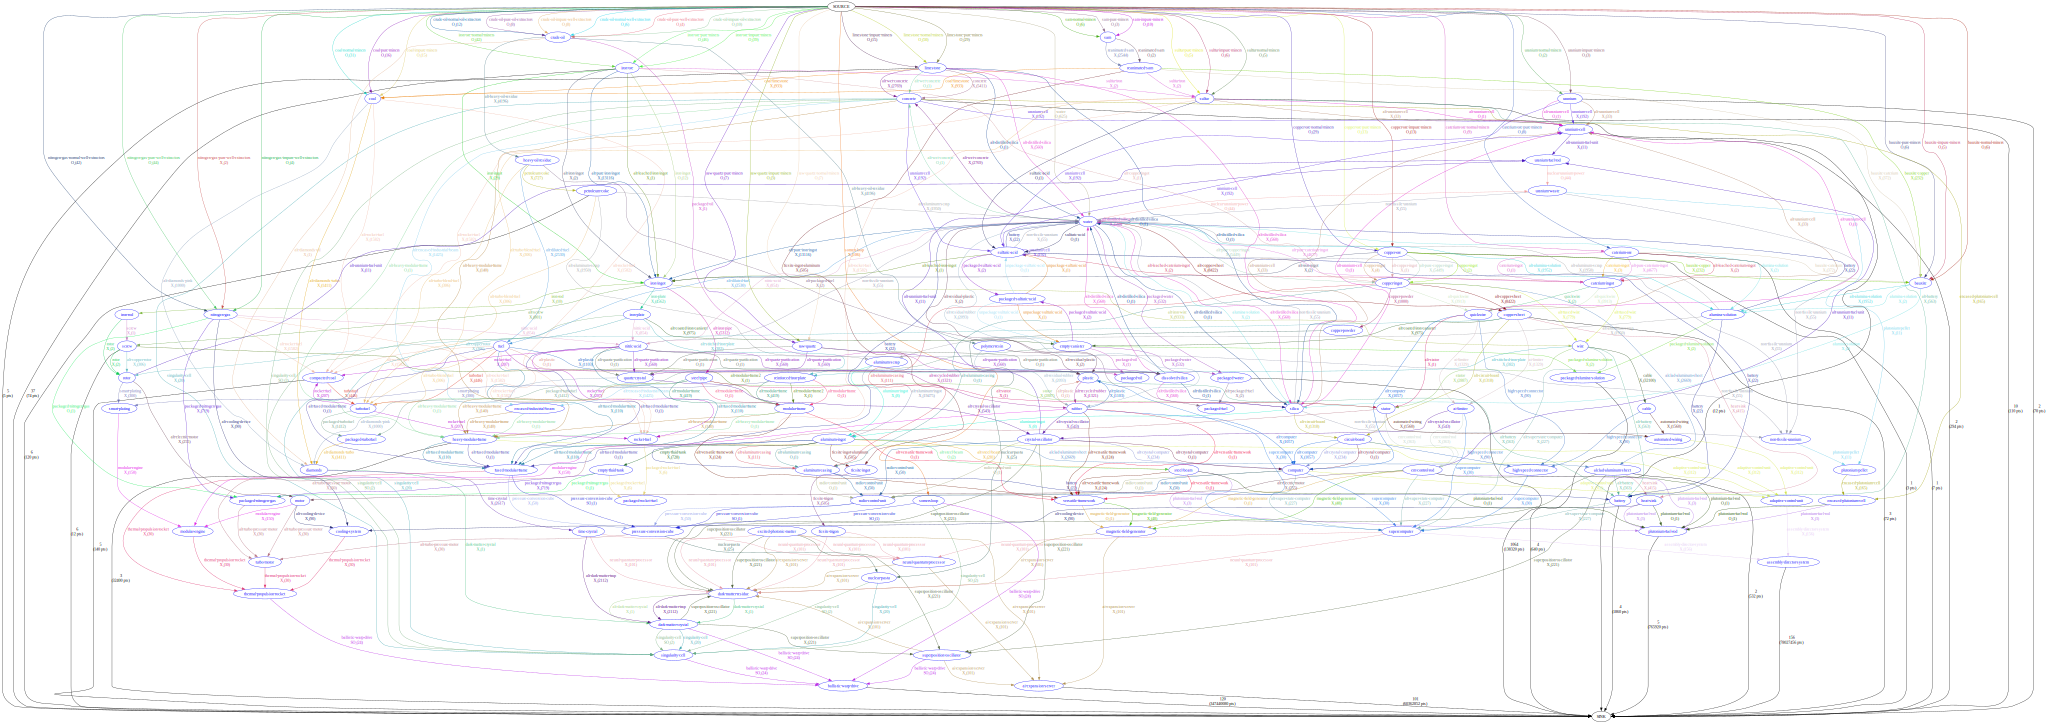

In [101]:
graph_recipes(res_full[1], min_produced=1)

In [102]:
def graph_all_individual_items(res_df):
    res_df = res_df[res_df['qty_produce'] > 0].copy()
    all_recipe_items = sorted(list(set(res_df['ingredients'].explode().dropna().apply(lambda x: x[0]).tolist() + res_df['products'].explode().dropna().apply(lambda x: x[0]).tolist())))
    
    for item in all_recipe_items:
#         if not item == 'bauxite':continue
        display(Markdown(f'## {item}'))
        plot_df = res_df[res_df.apply(lambda x: any([(len(y) and y[0] == item) for y in x['ingredients'] + x['products']]), axis=1)]
#         display(plot_df)
        graph_recipes(plot_df)
        
        

## adaptive-control-unit

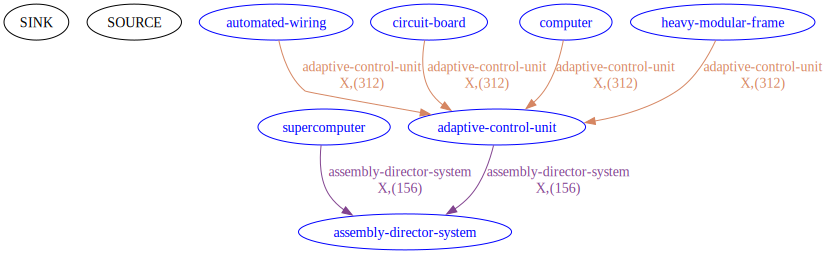

## ai-expansion-server

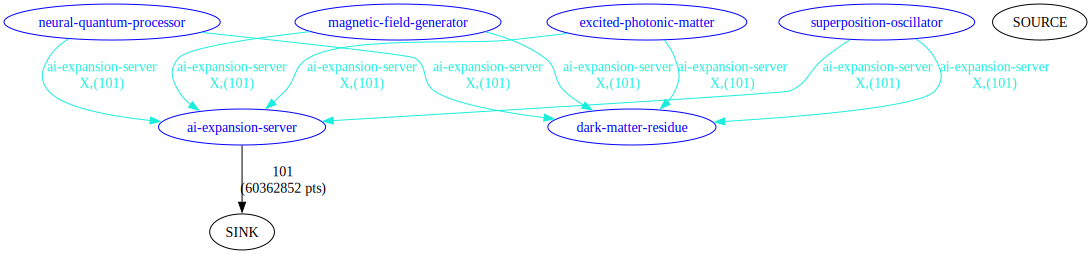

## ai-limiter

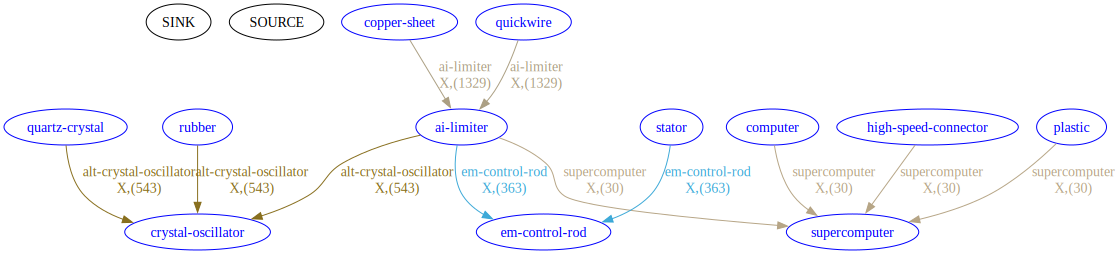

## alclad-aluminum-sheet

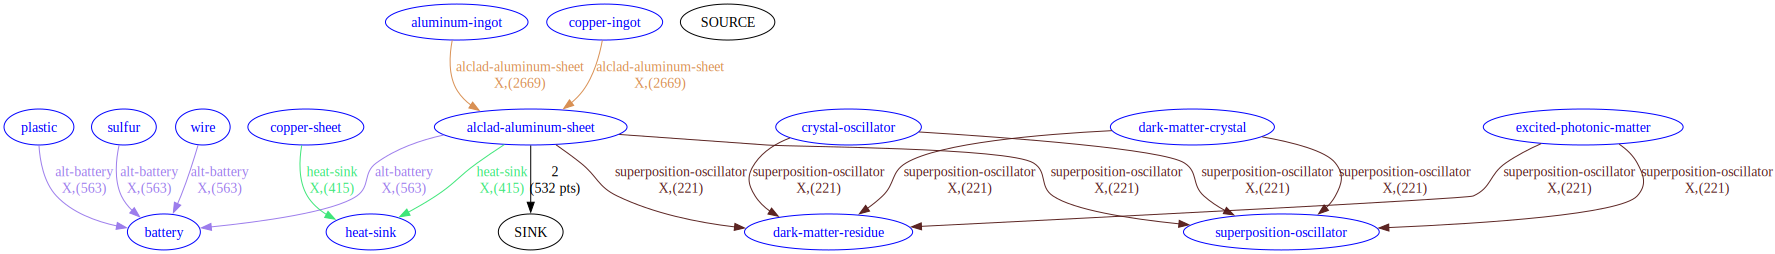

## alumina-solution

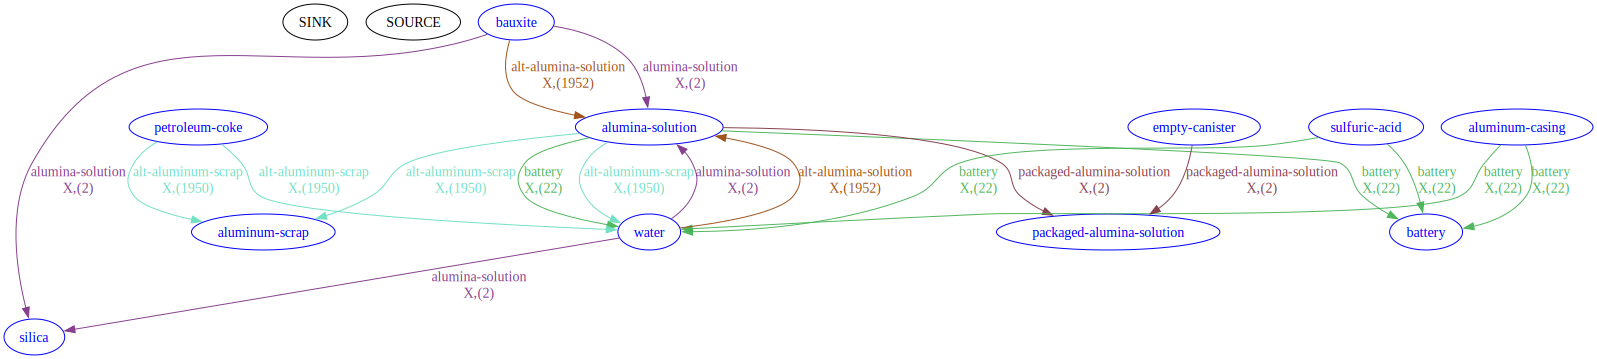

## aluminum-casing

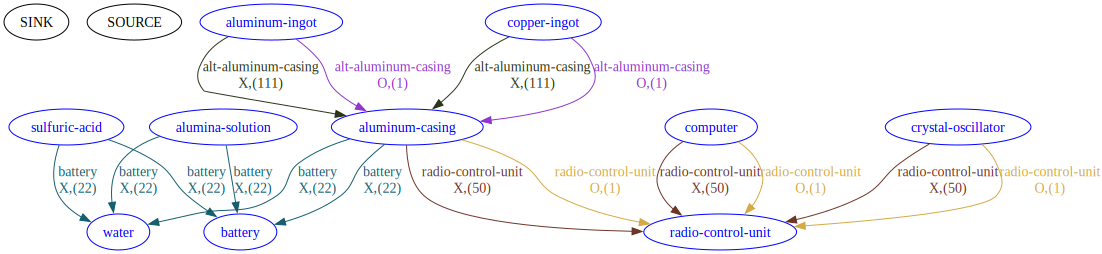

## aluminum-ingot

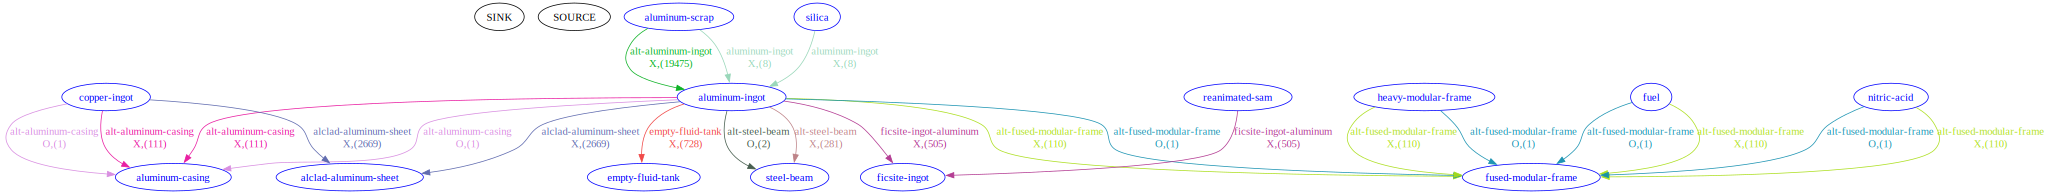

## aluminum-scrap

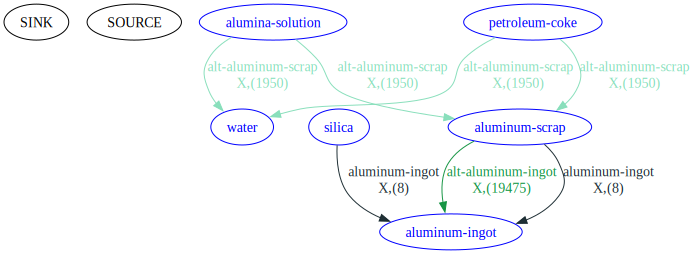

## assembly-director-system

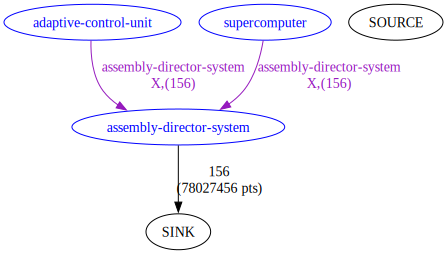

## automated-wiring

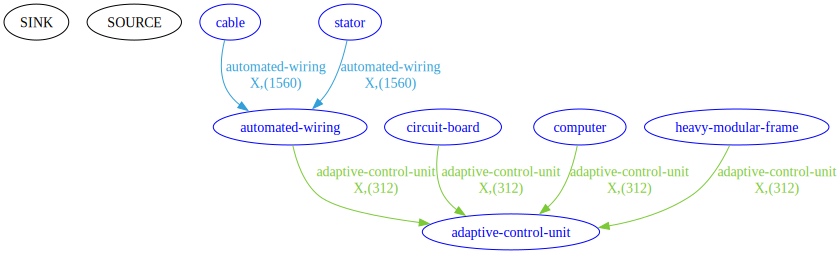

## ballistic-warp-drive

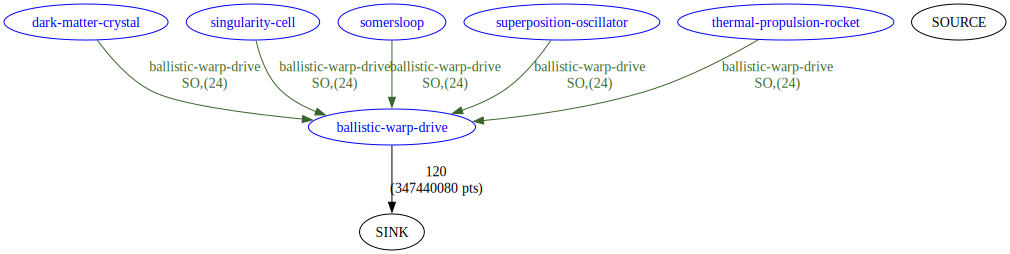

## battery

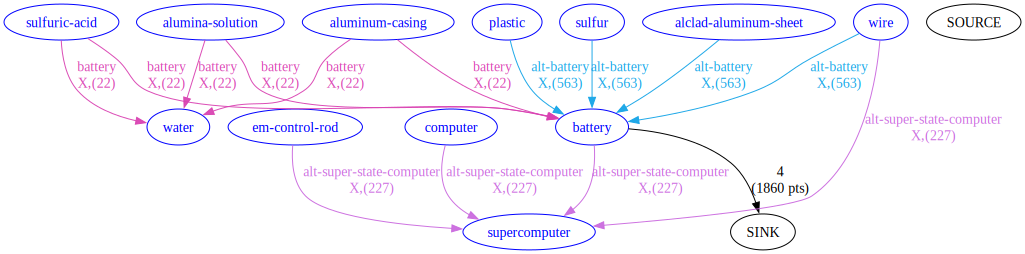

## bauxite

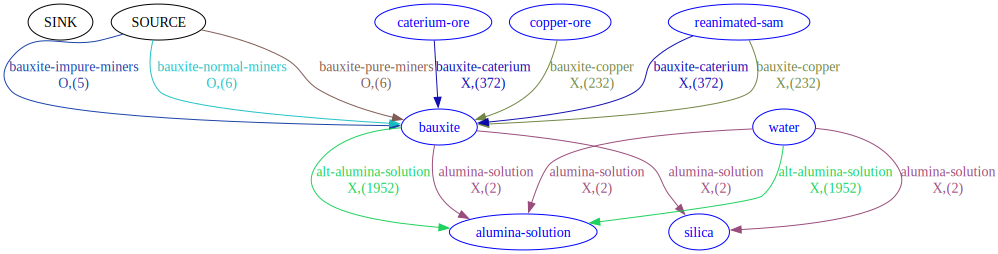

## cable

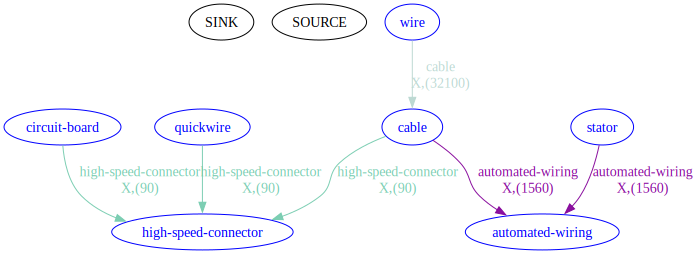

## caterium-ingot

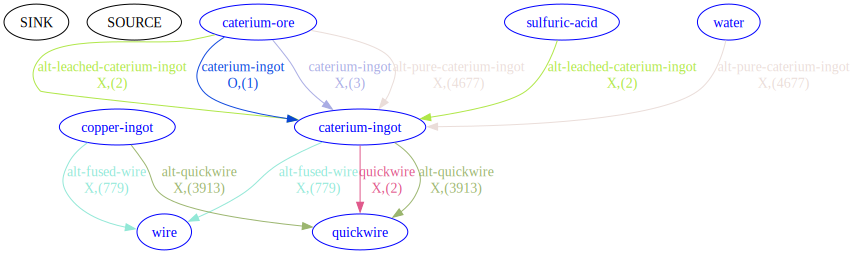

## caterium-ore

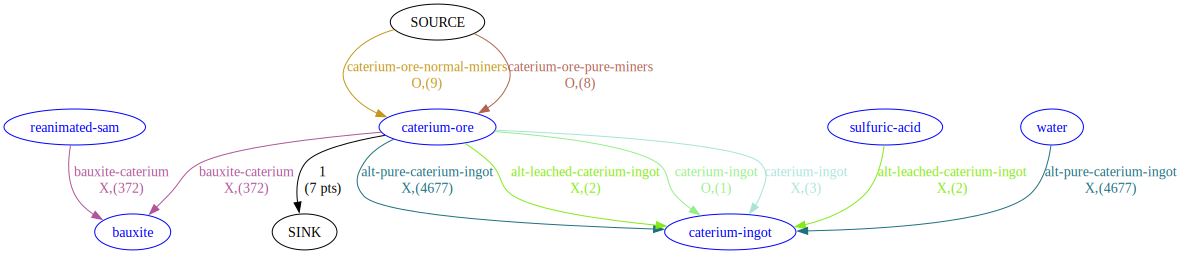

## circuit-board

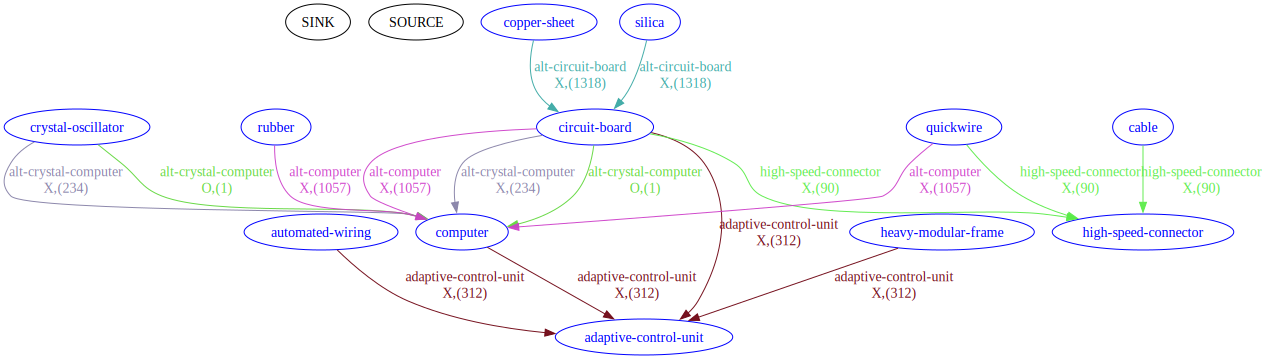

## coal

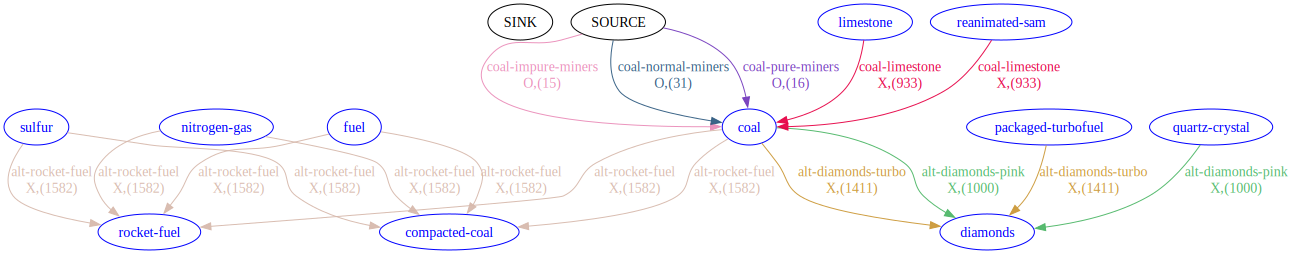

## compacted-coal

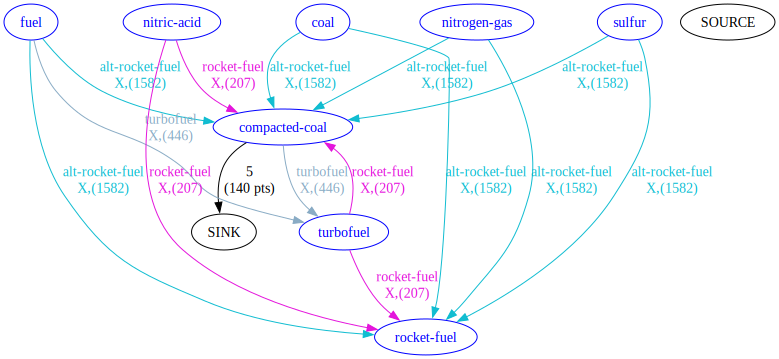

## computer

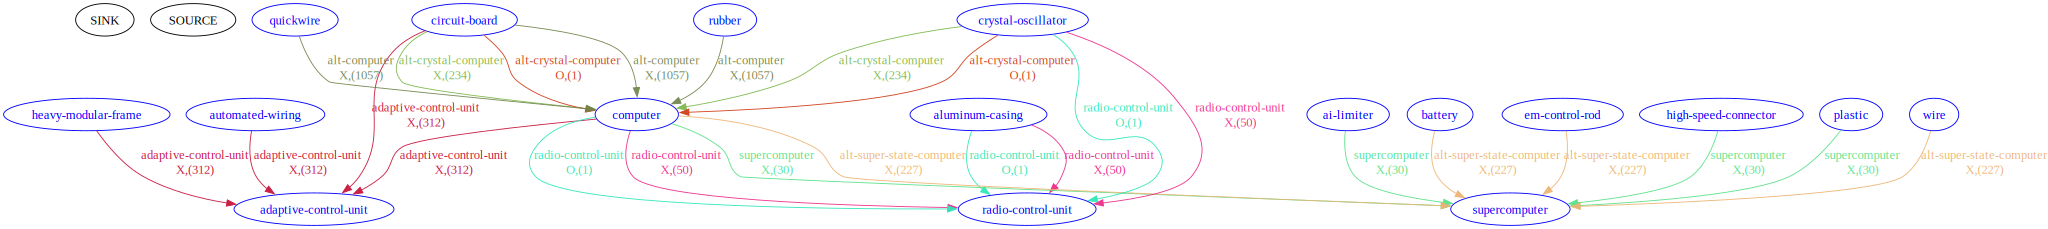

## concrete

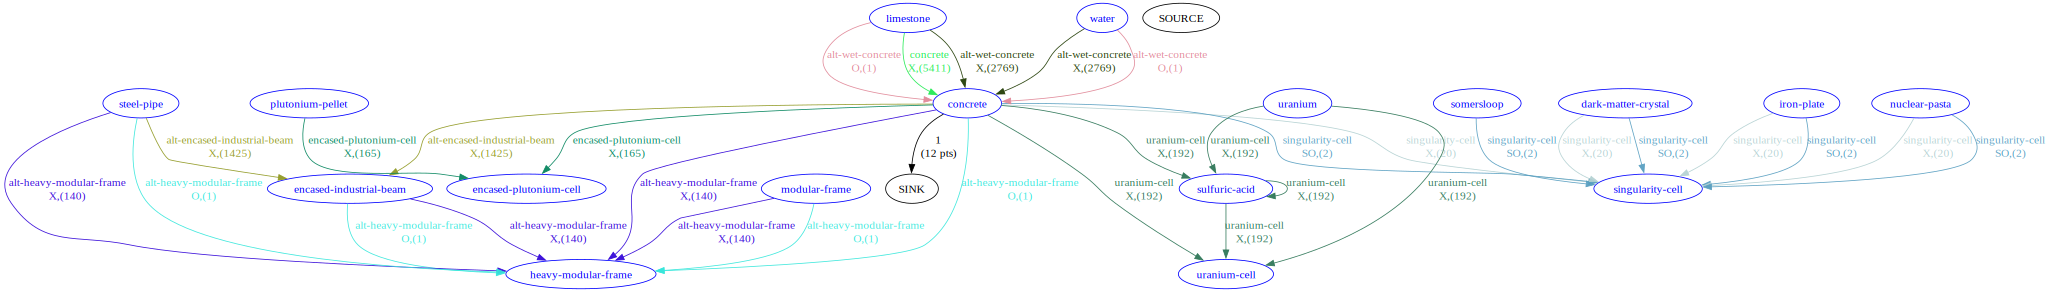

## cooling-system

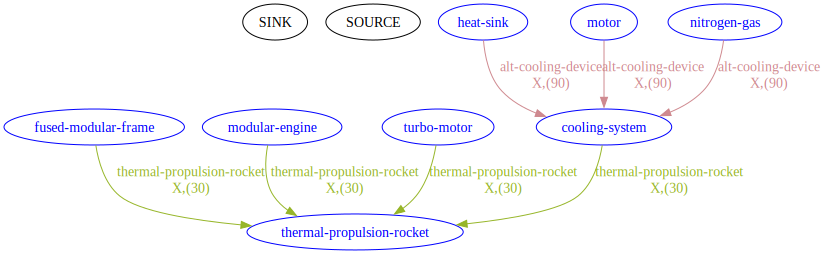

## copper-ingot

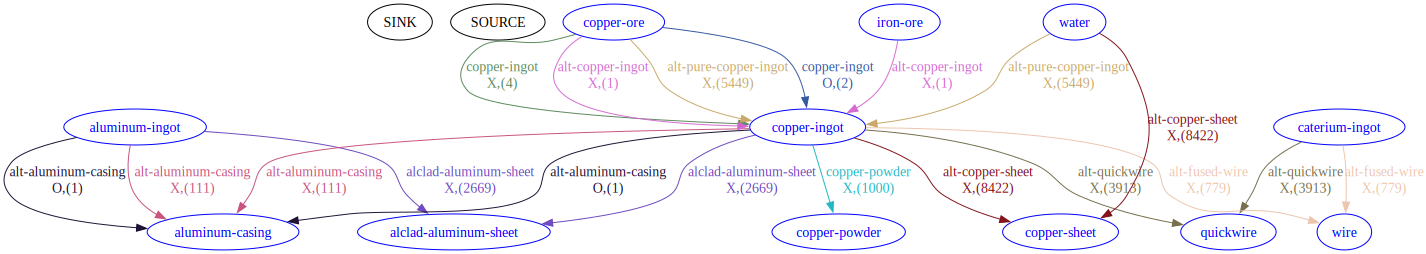

## copper-ore

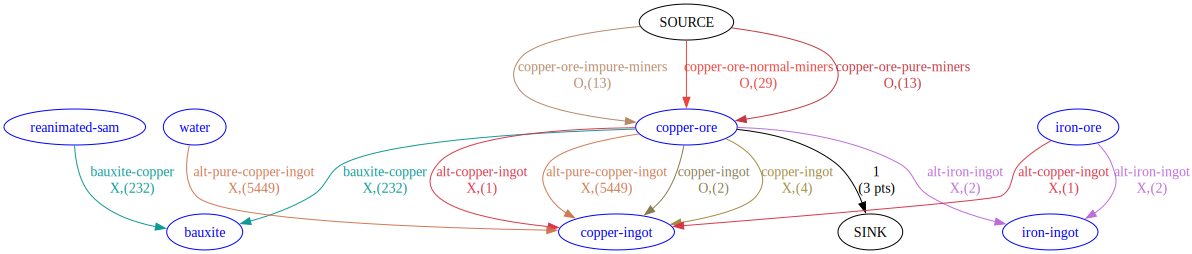

## copper-powder

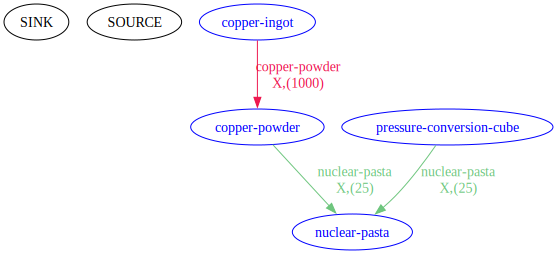

## copper-sheet

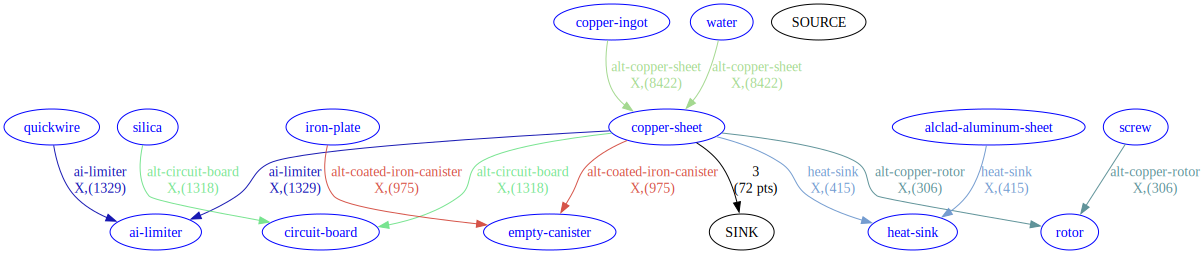

## crude-oil

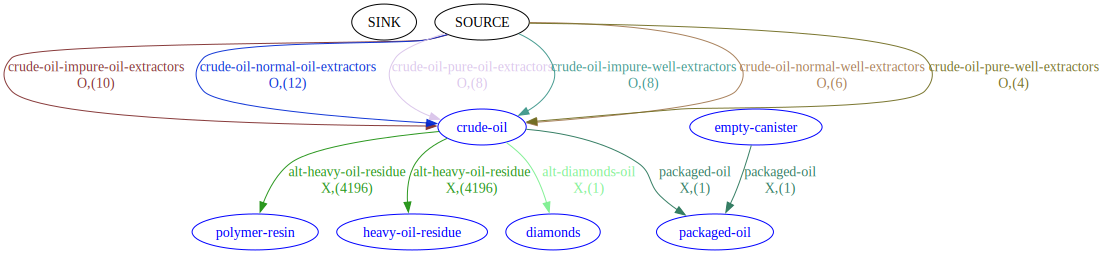

## crystal-oscillator

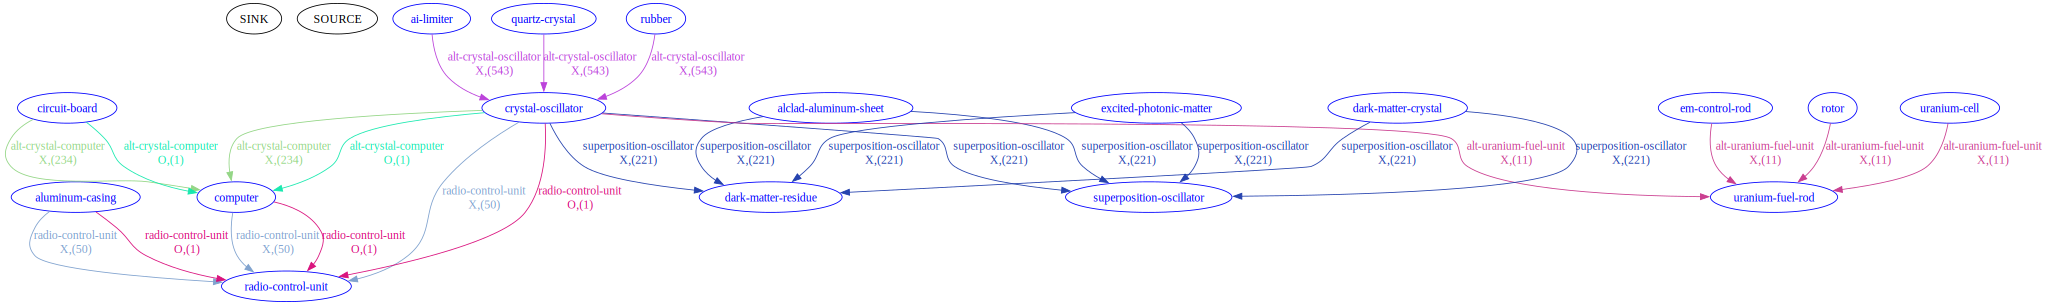

## dark-matter-crystal

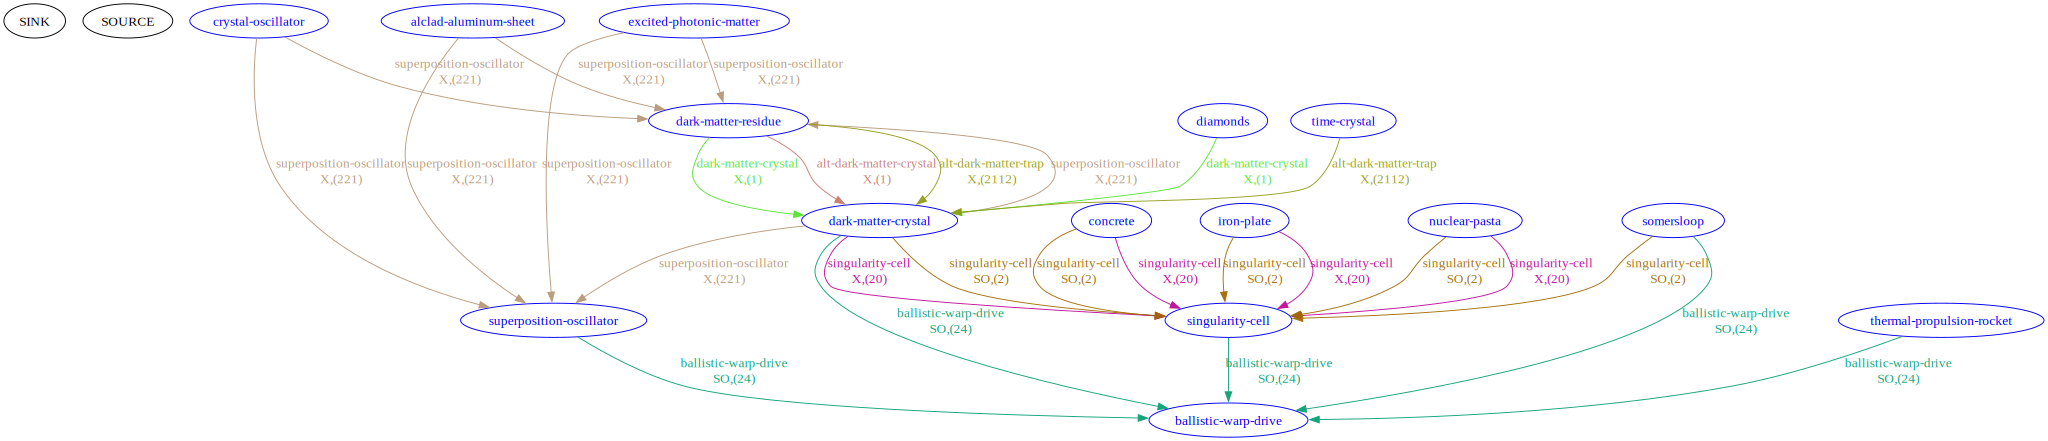

## dark-matter-residue

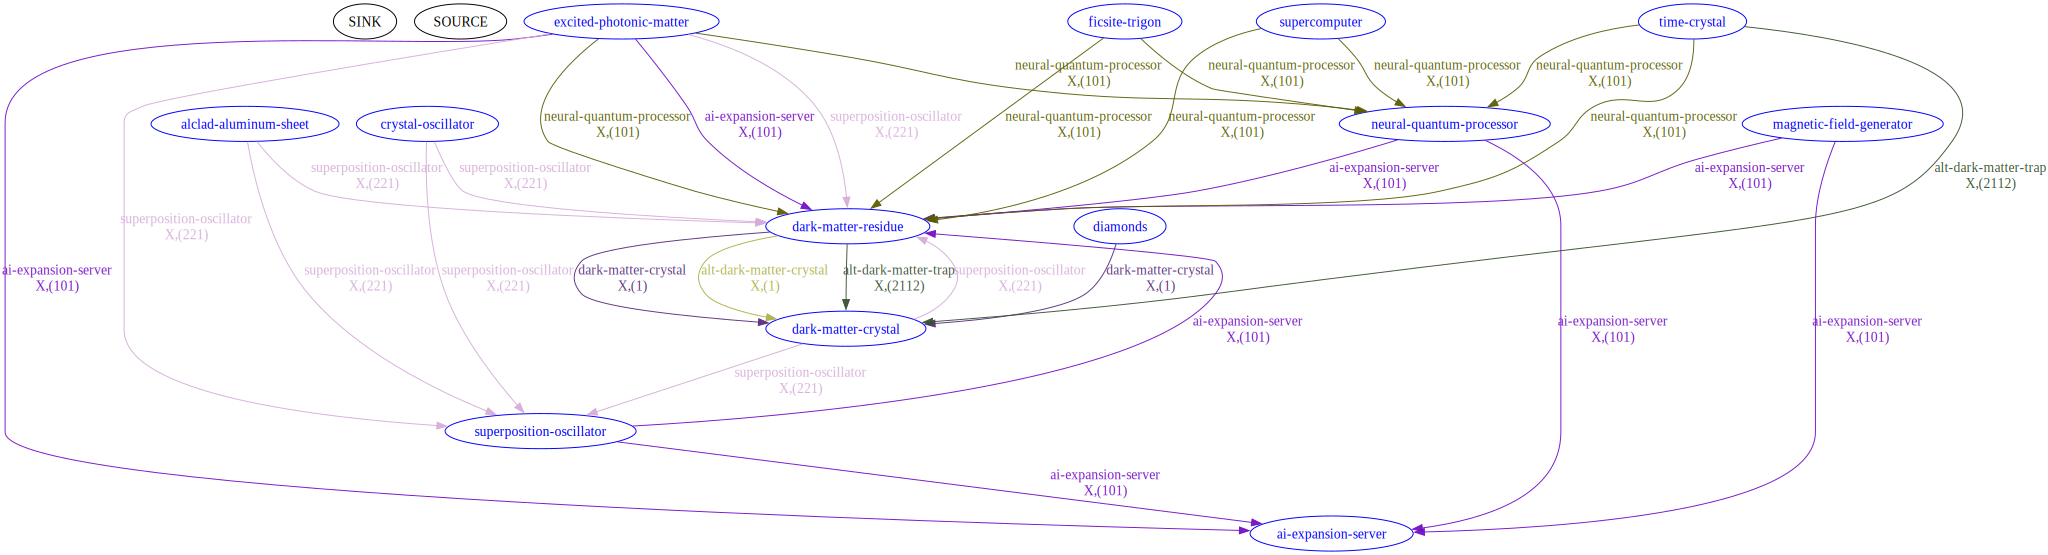

## diamonds

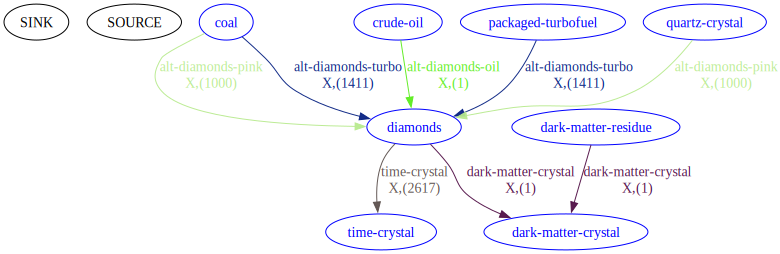

## dissolved-silica

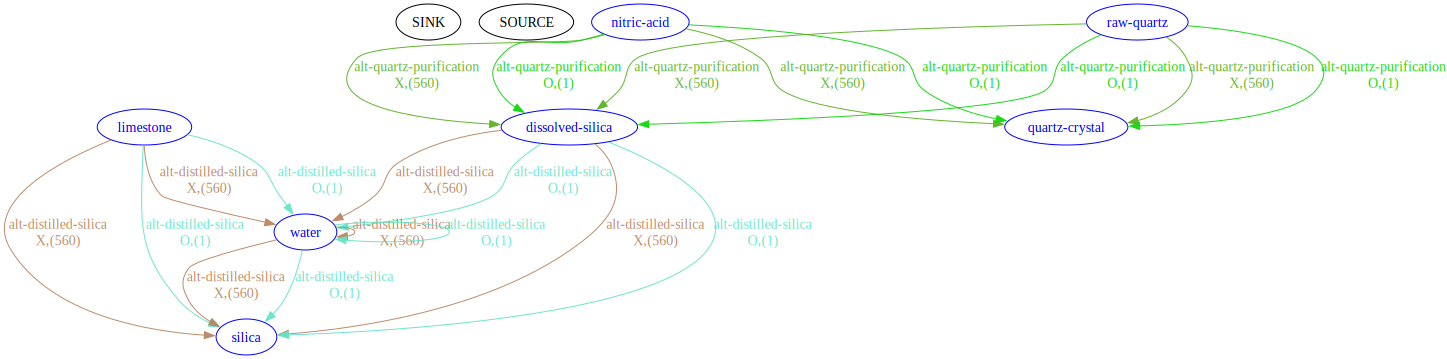

## em-control-rod

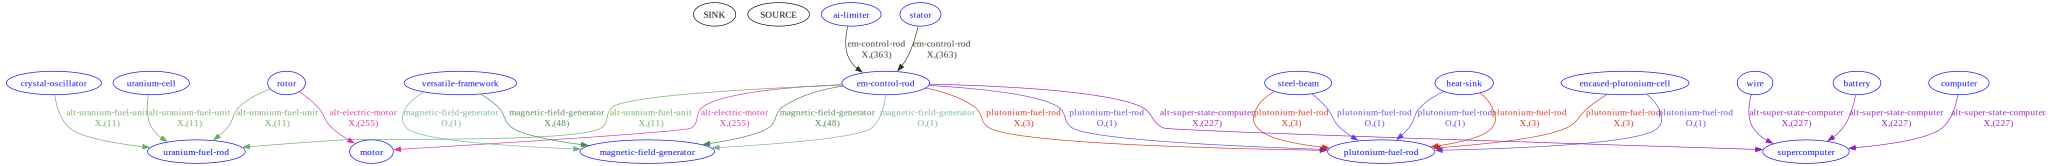

## empty-canister

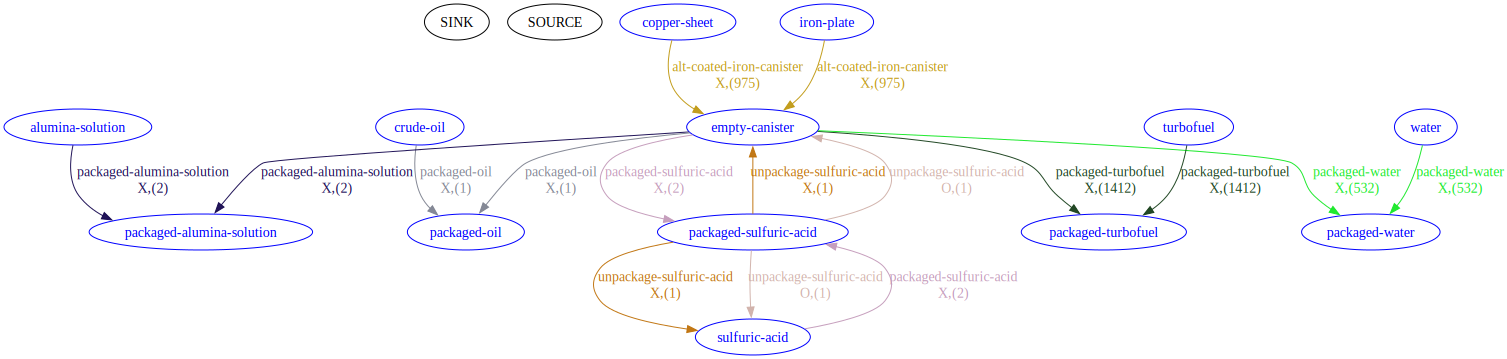

## empty-fluid-tank

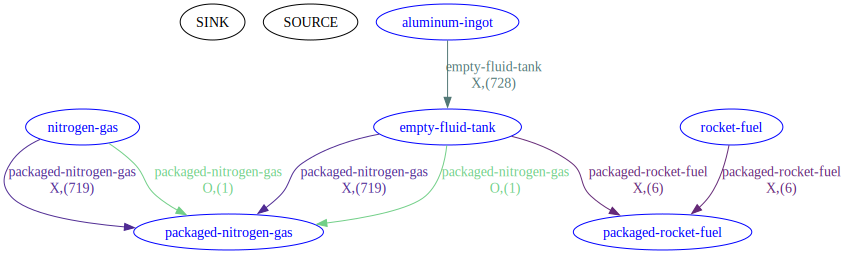

## encased-industrial-beam

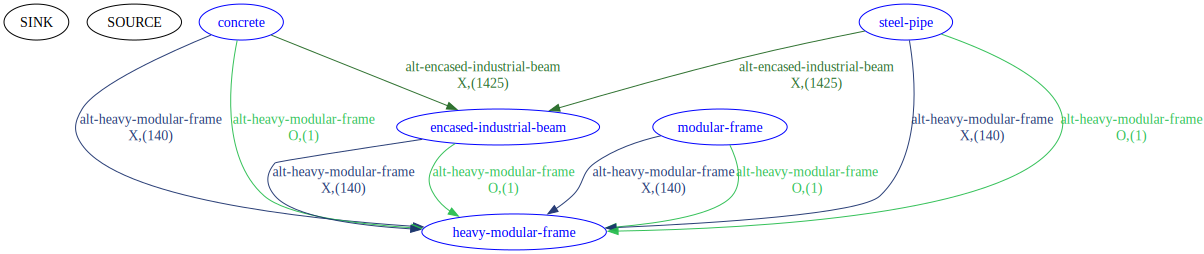

## encased-plutonium-cell

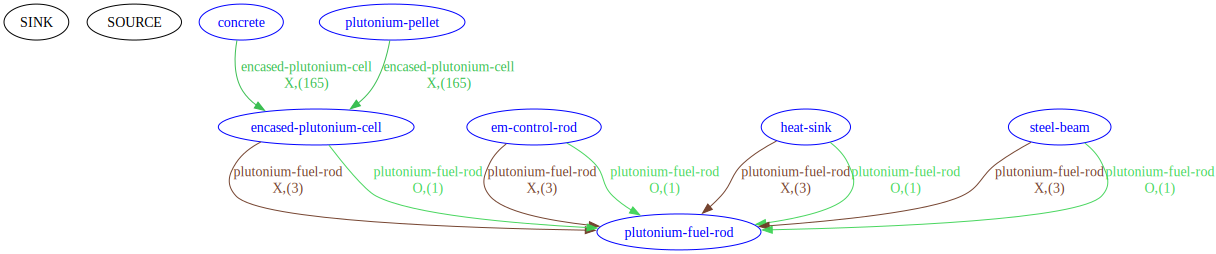

## excited-photonic-matter

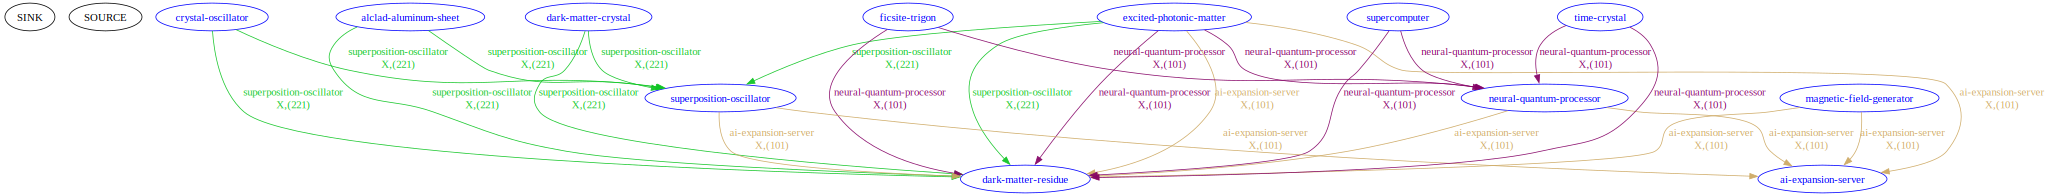

## ficsite-ingot

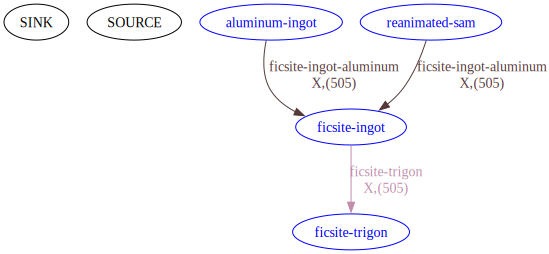

## ficsite-trigon

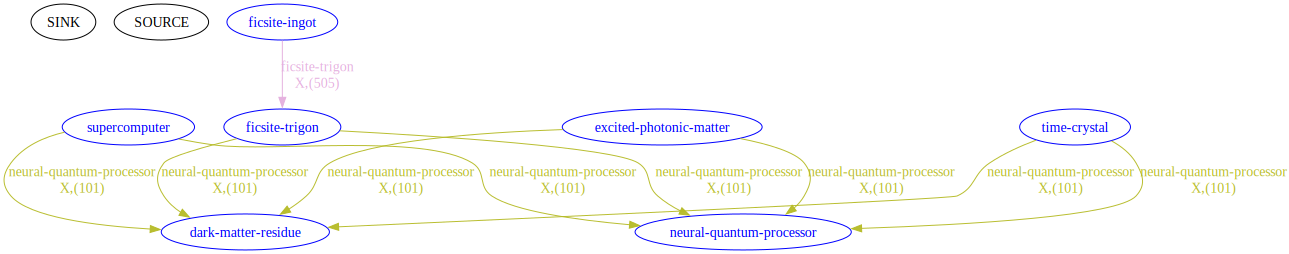

## fuel

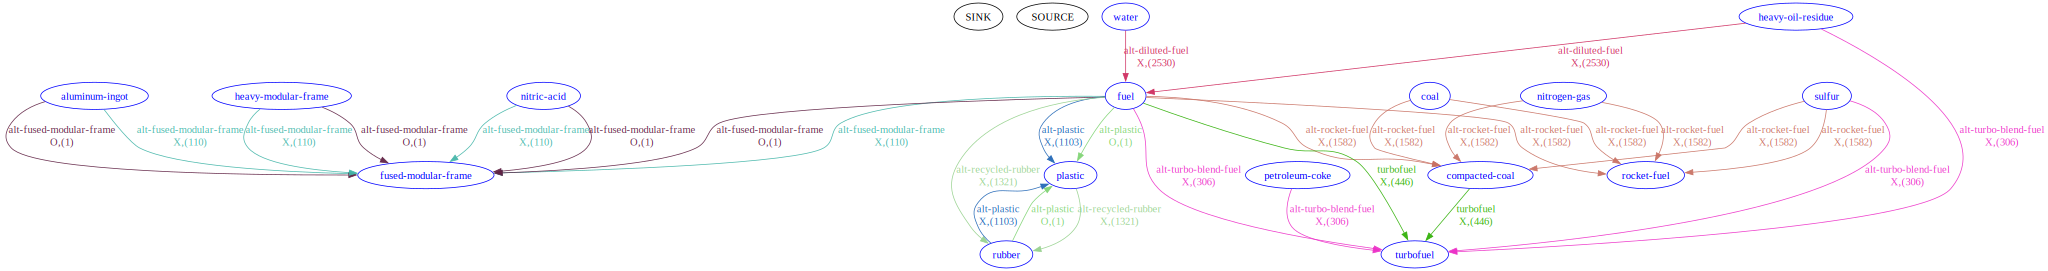

## fused-modular-frame

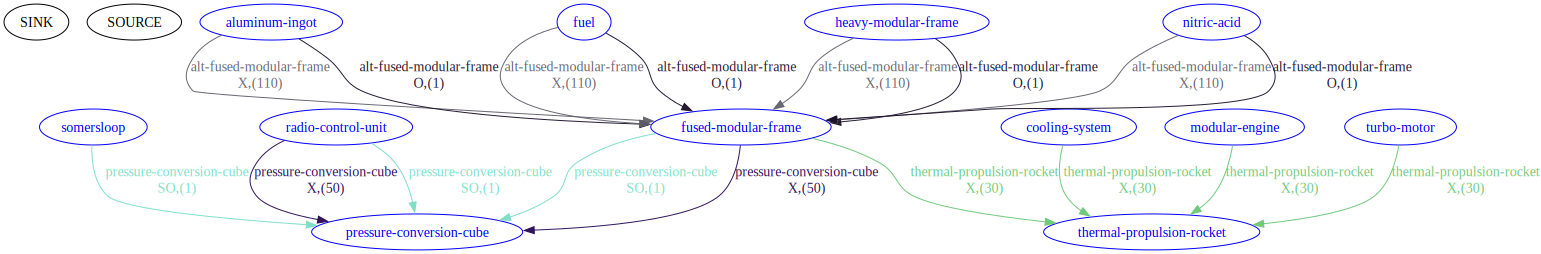

## heat-sink

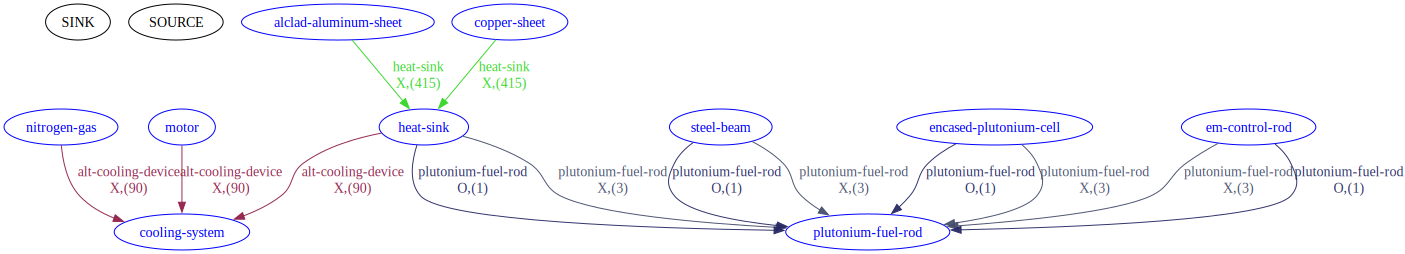

## heavy-modular-frame

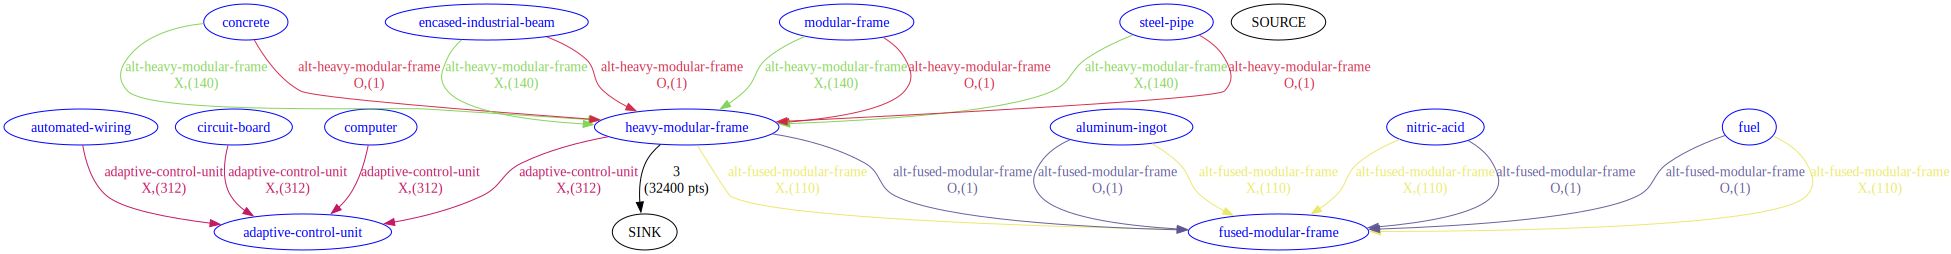

## heavy-oil-residue

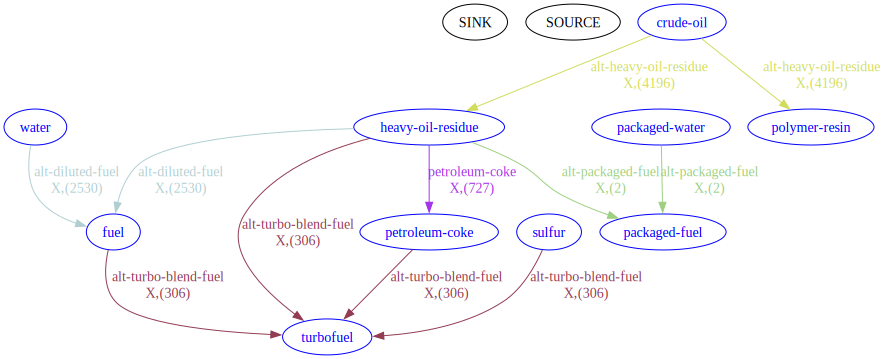

## high-speed-connector

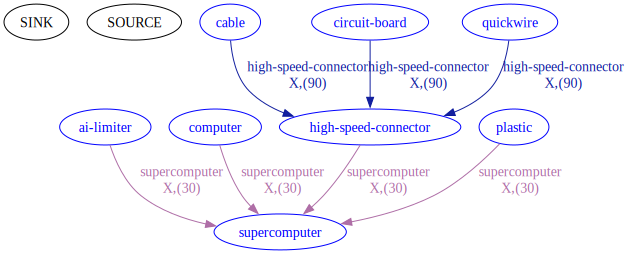

## iron-ingot

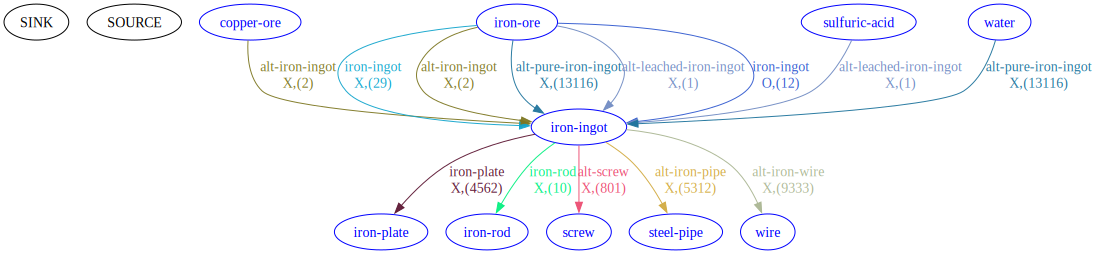

## iron-ore

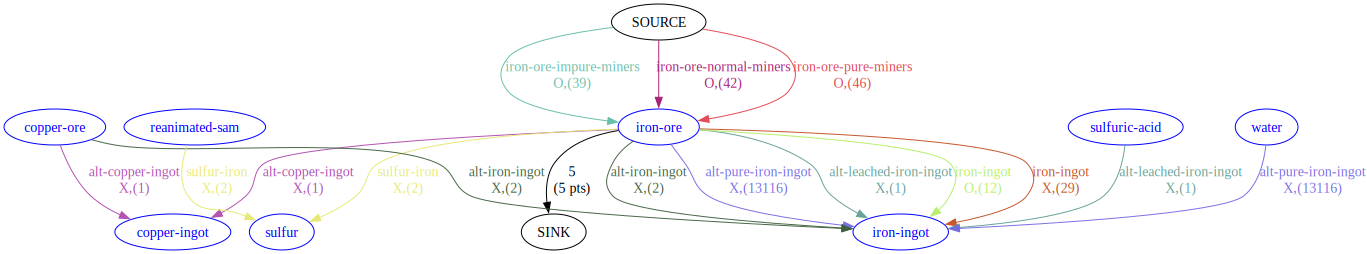

## iron-plate

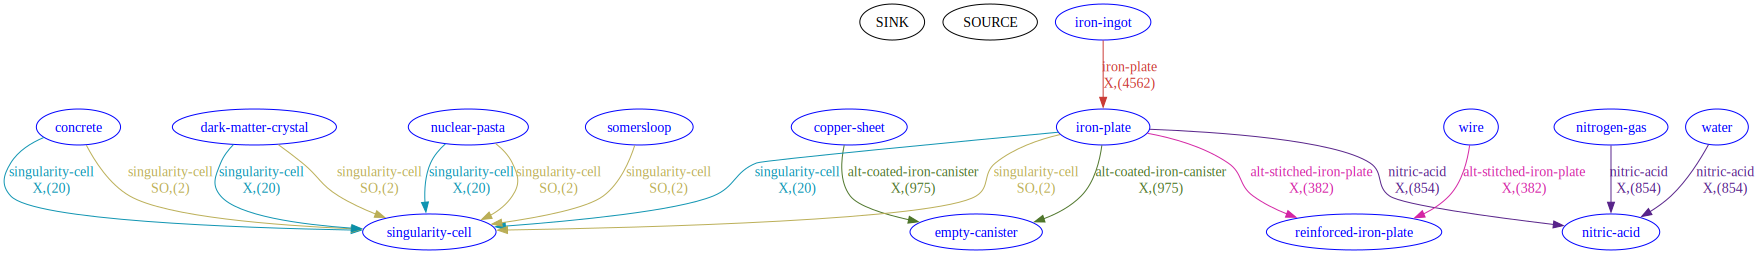

## iron-rod

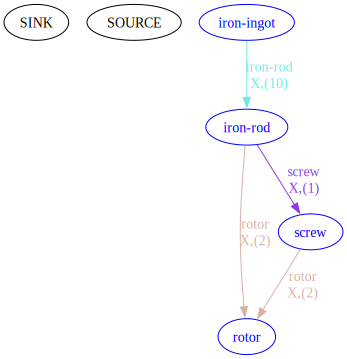

## limestone

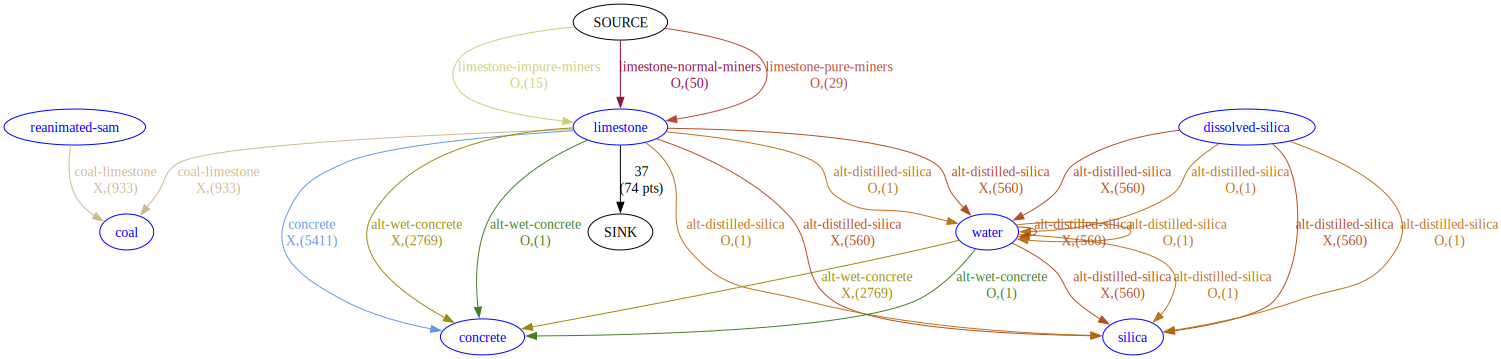

## magnetic-field-generator

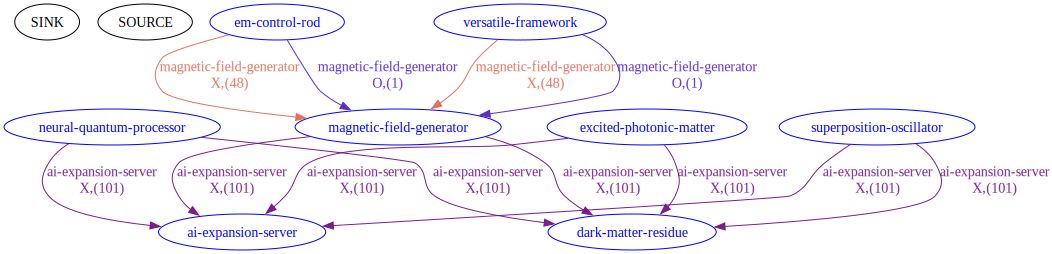

## modular-engine

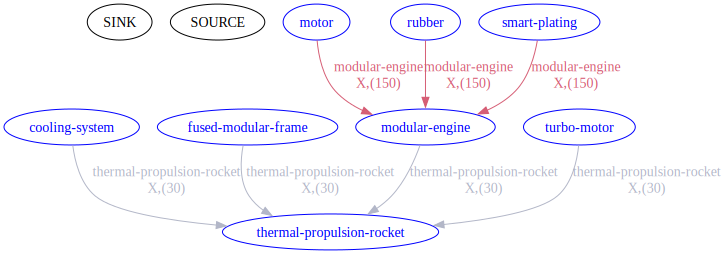

## modular-frame

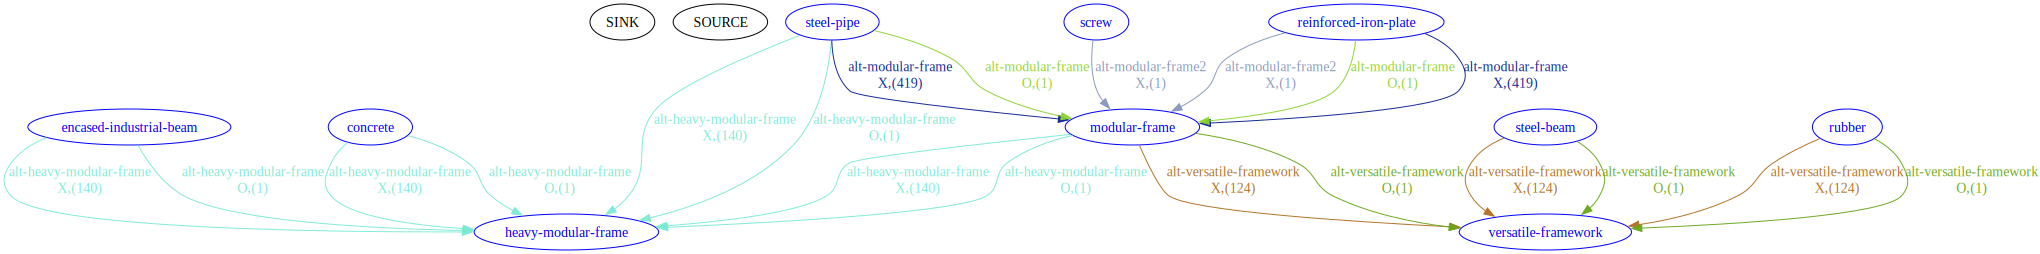

## motor

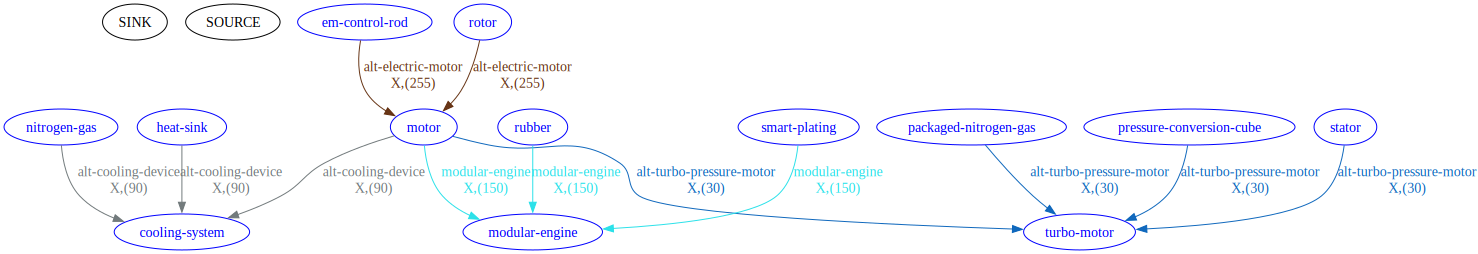

## neural-quantum-processor

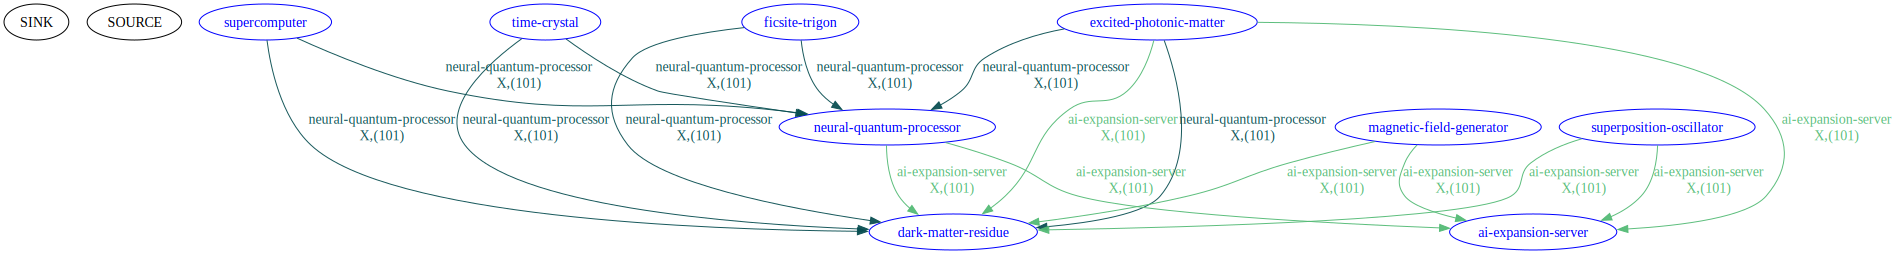

## nitric-acid

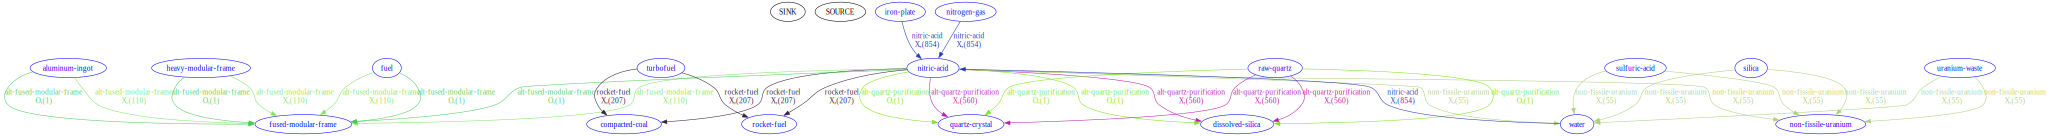

## nitrogen-gas

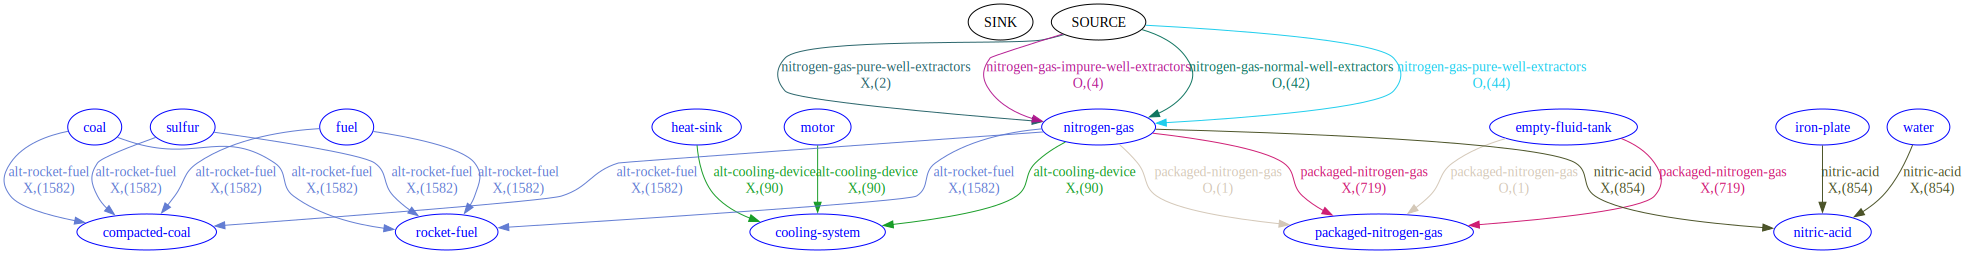

## non-fissile-uranium

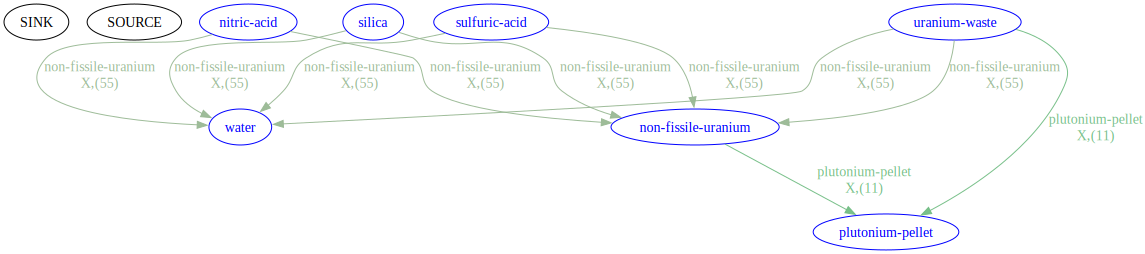

## nuclear-pasta

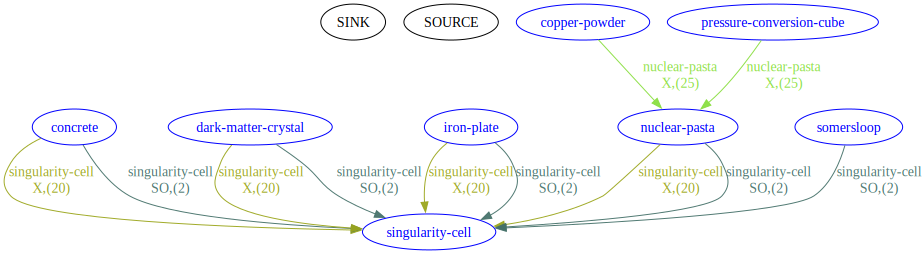

## packaged-alumina-solution

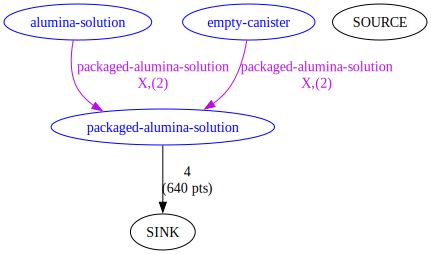

## packaged-fuel

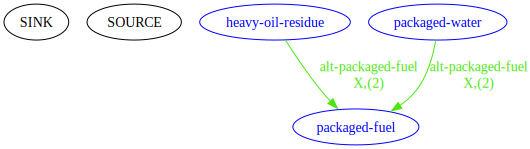

## packaged-nitrogen-gas

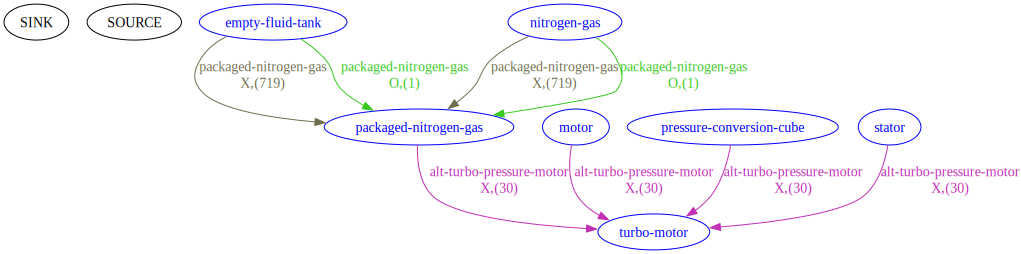

## packaged-oil

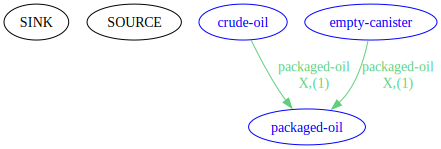

## packaged-rocket-fuel

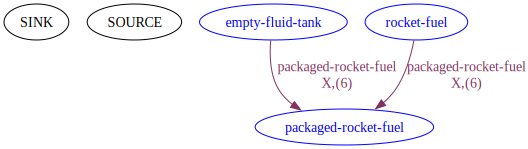

## packaged-sulfuric-acid

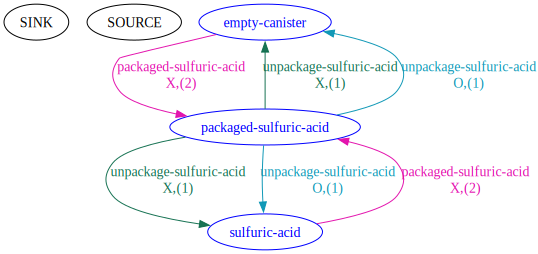

## packaged-turbofuel

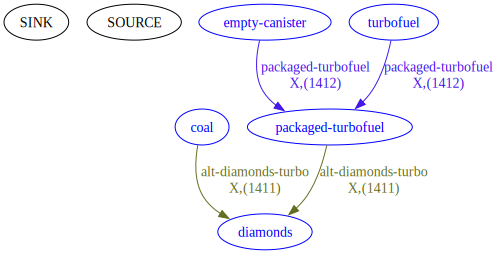

## packaged-water

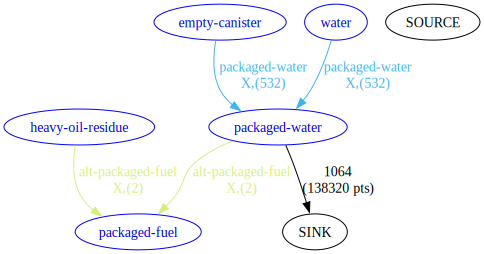

## petroleum-coke

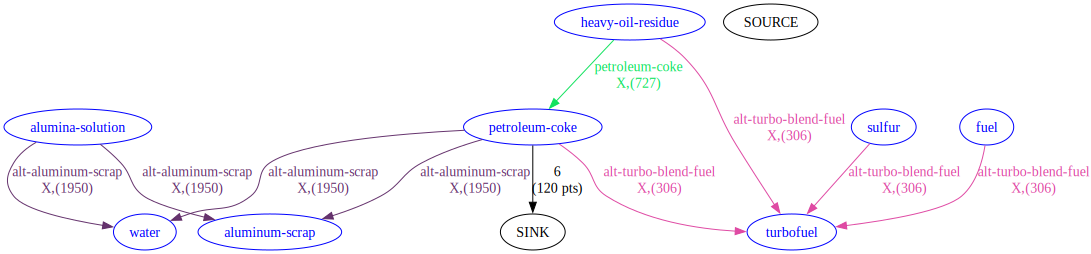

## plastic

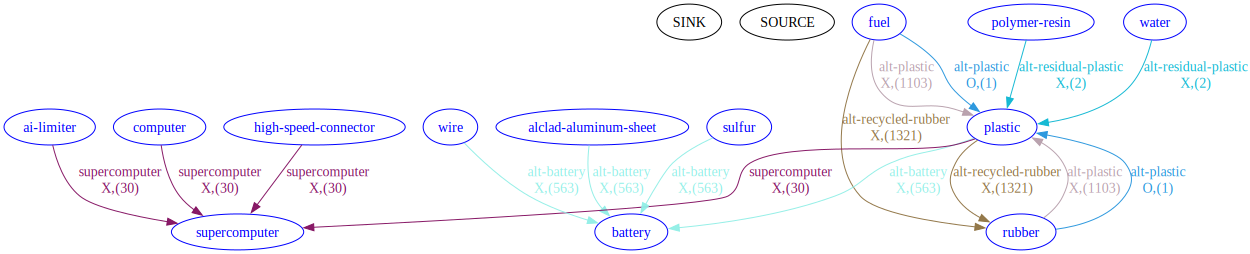

## plutonium-fuel-rod

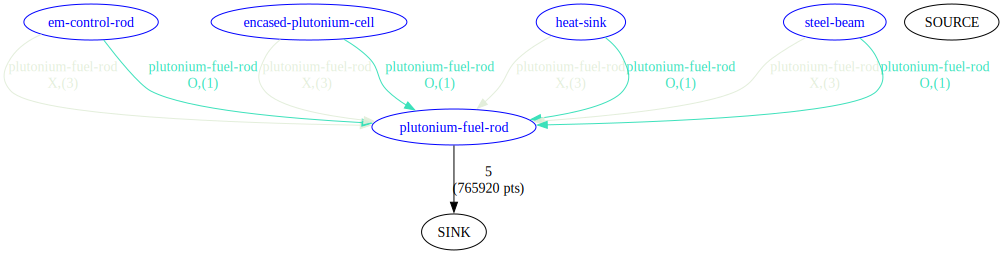

## plutonium-pellet

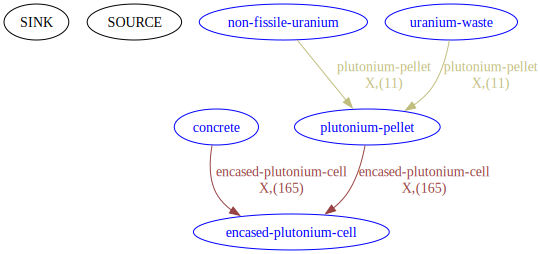

## polymer-resin

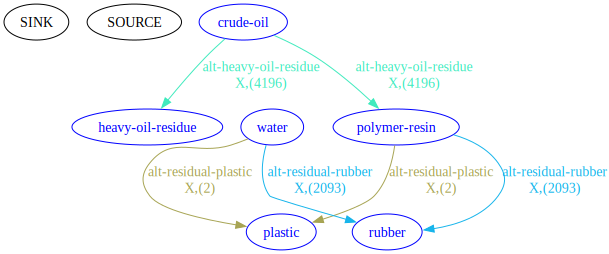

## pressure-conversion-cube

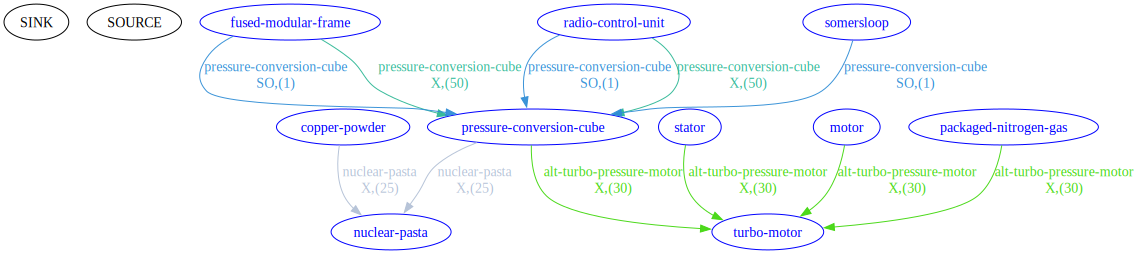

## quartz-crystal

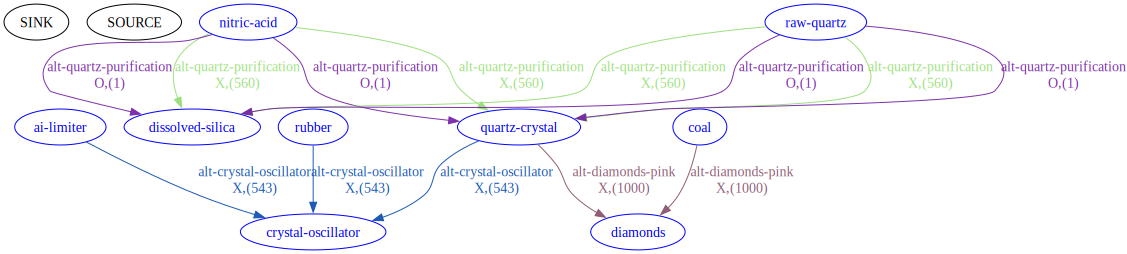

## quickwire

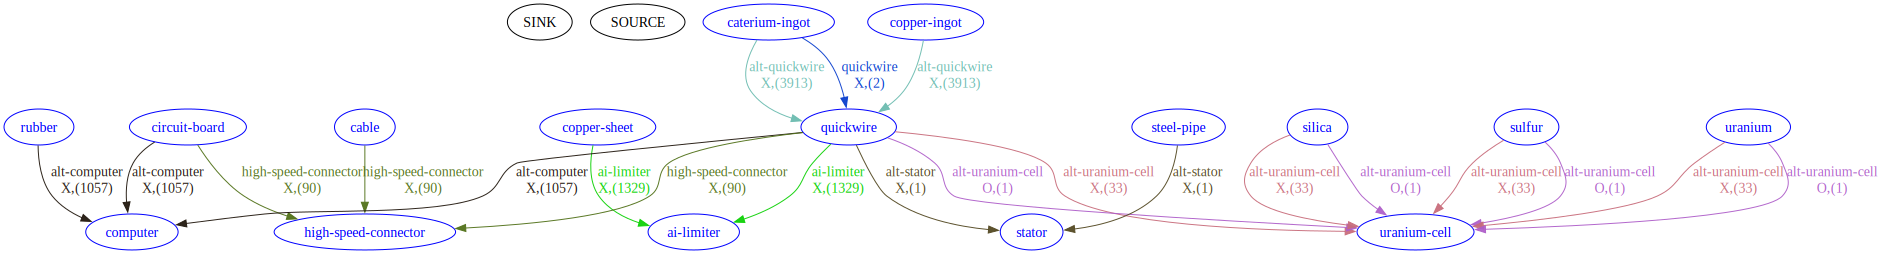

## radio-control-unit

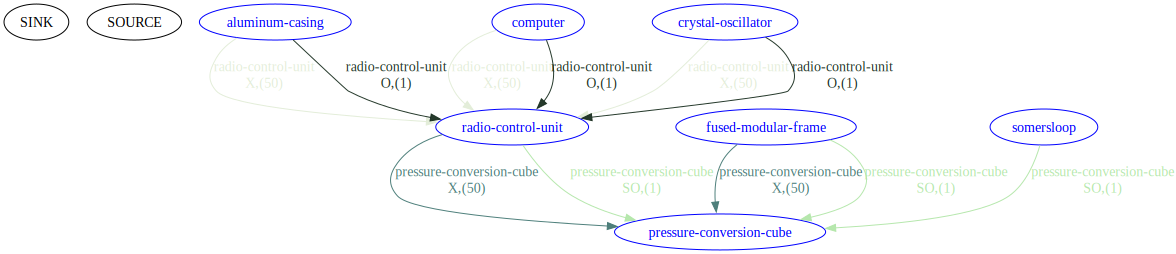

## raw-quartz

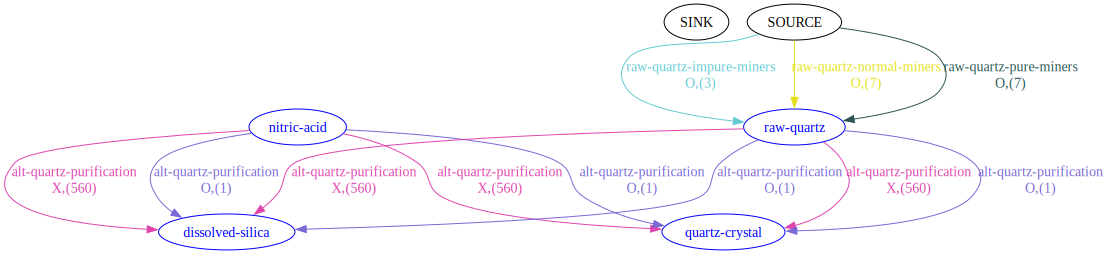

## reanimated-sam

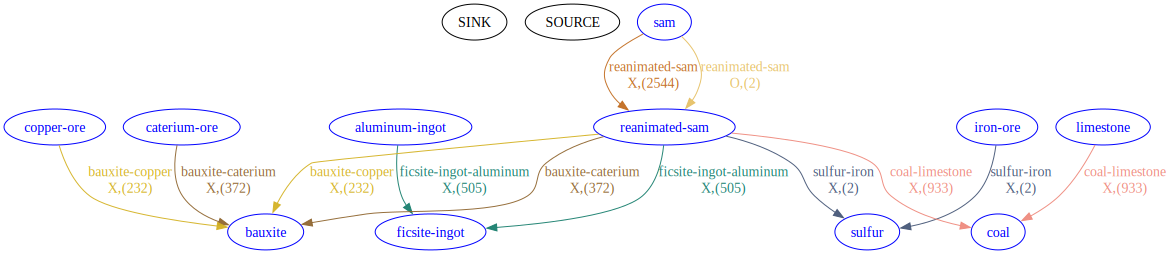

## reinforced-iron-plate

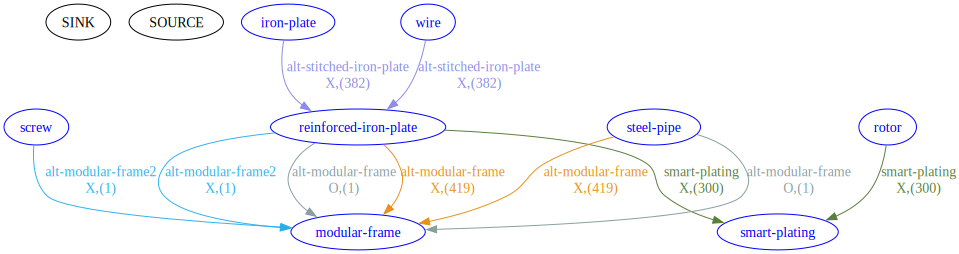

## rocket-fuel

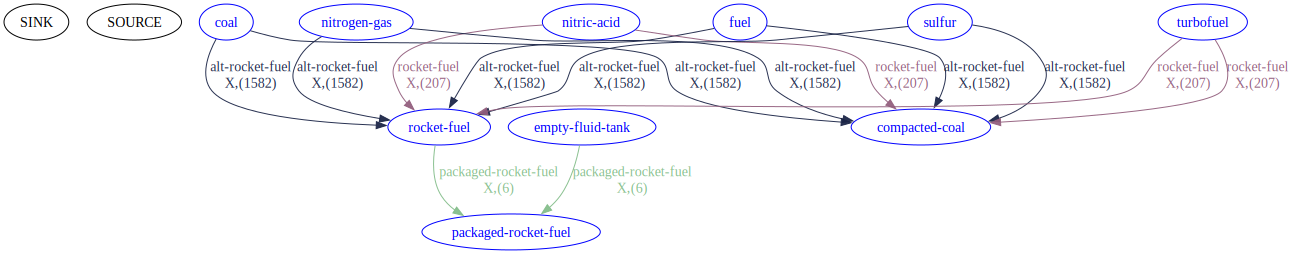

## rotor

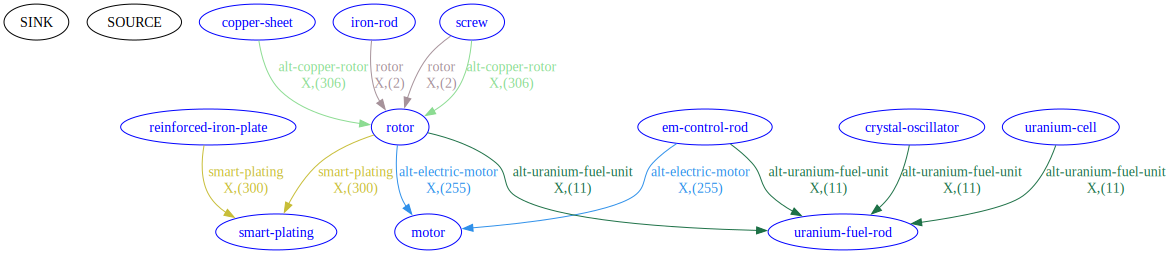

## rubber

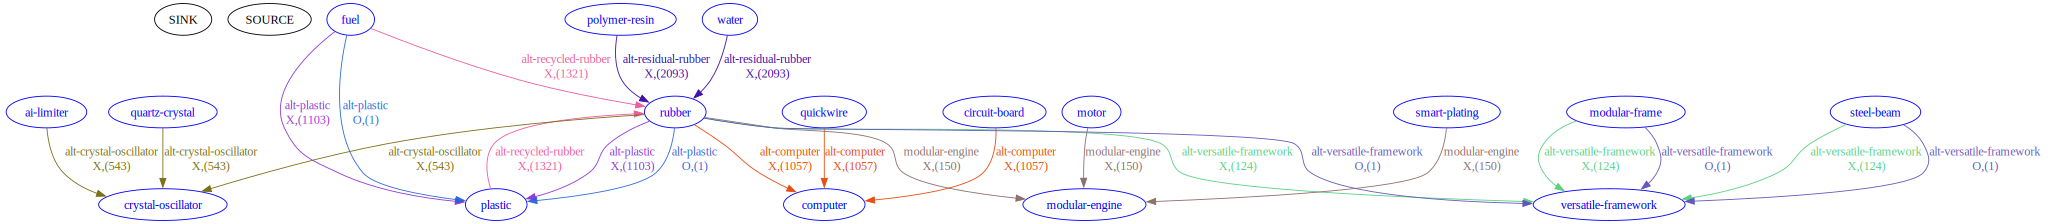

## sam

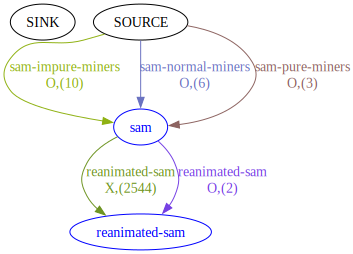

## screw

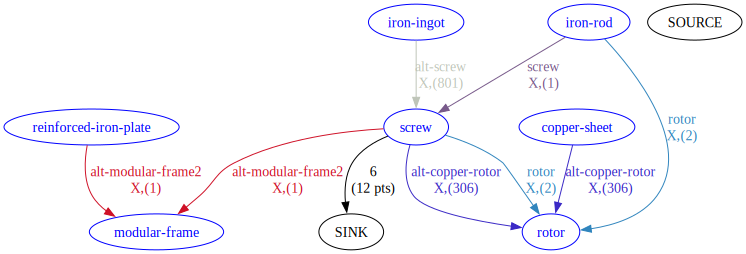

## silica

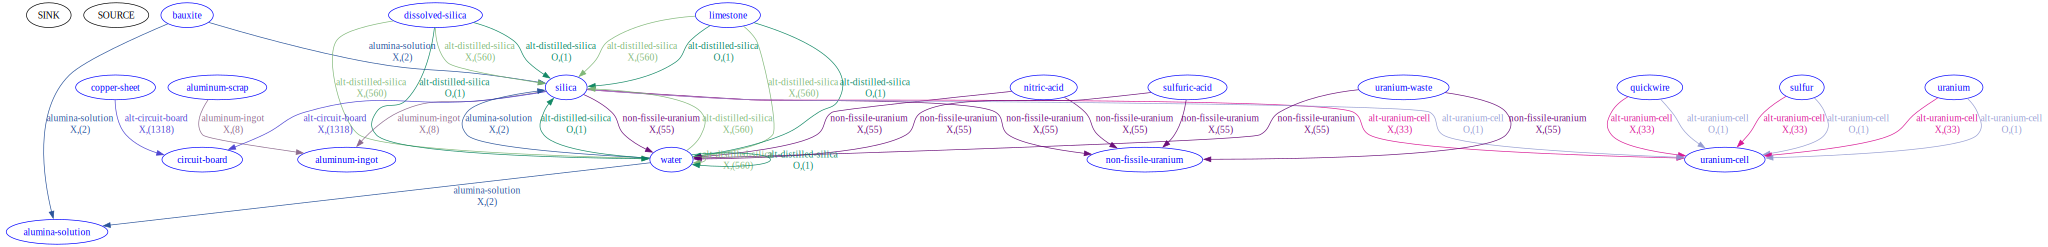

## singularity-cell

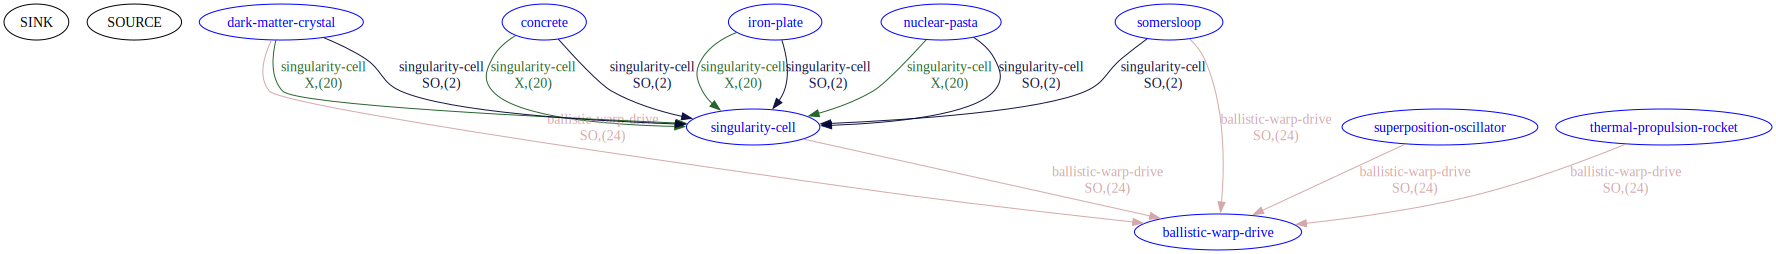

## smart-plating

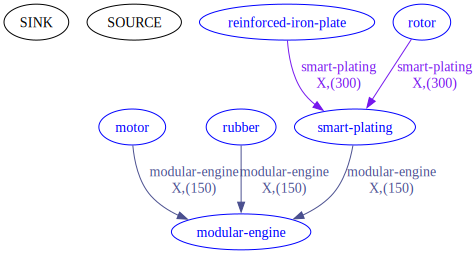

## somersloop

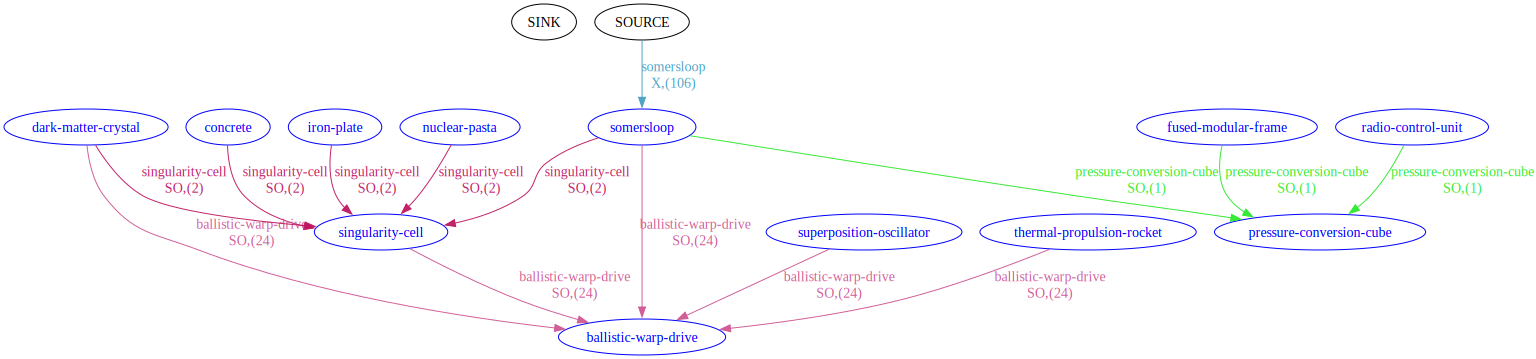

## stator

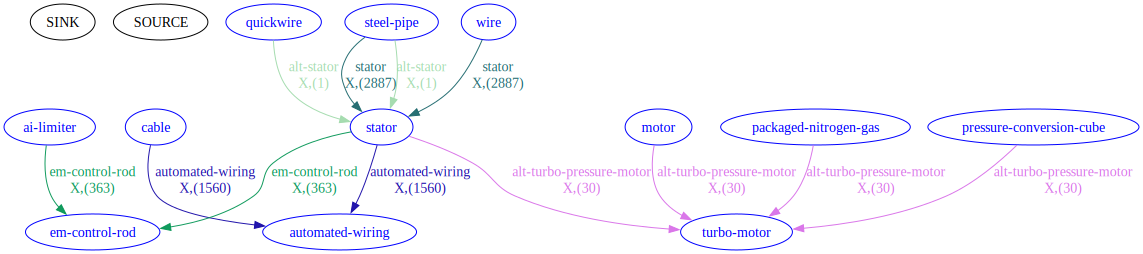

## steel-beam

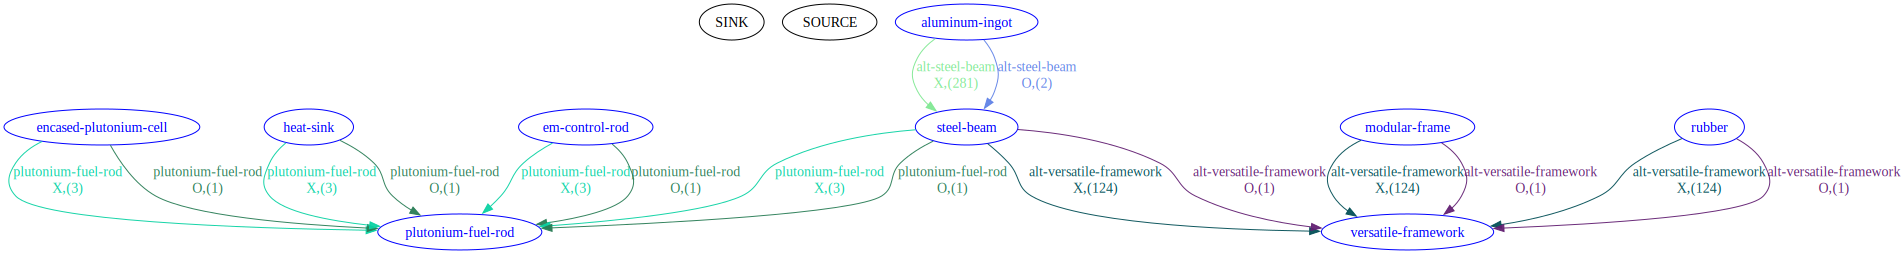

## steel-pipe

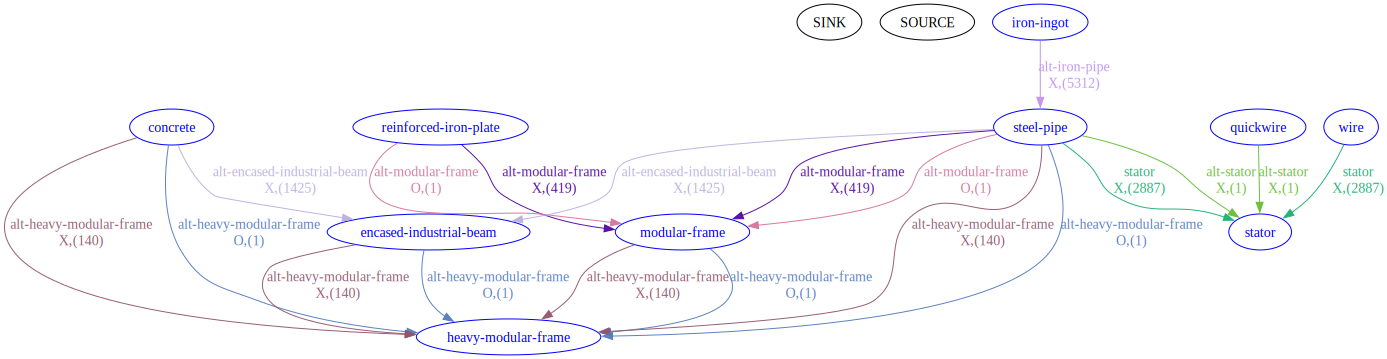

## sulfur

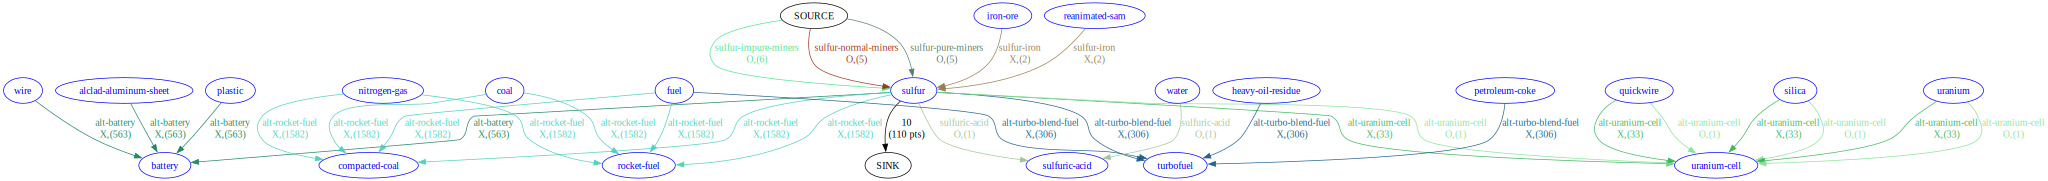

## sulfuric-acid

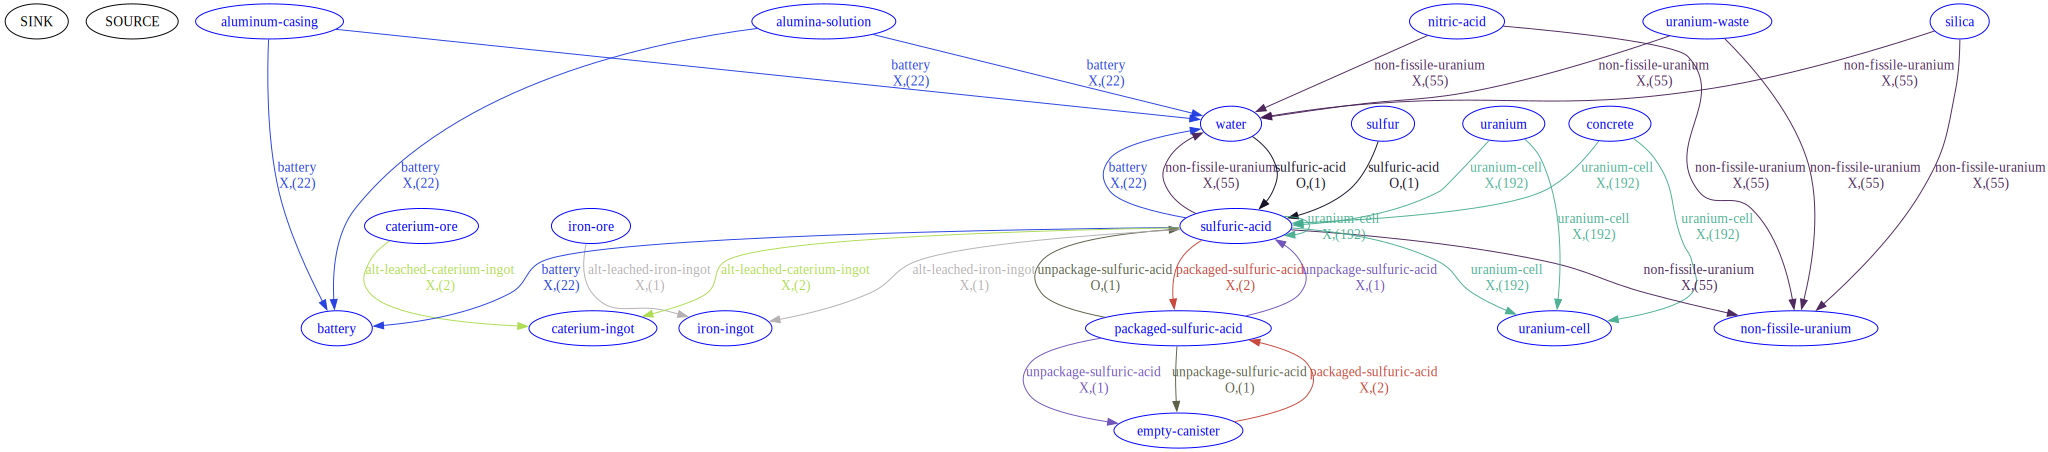

## supercomputer

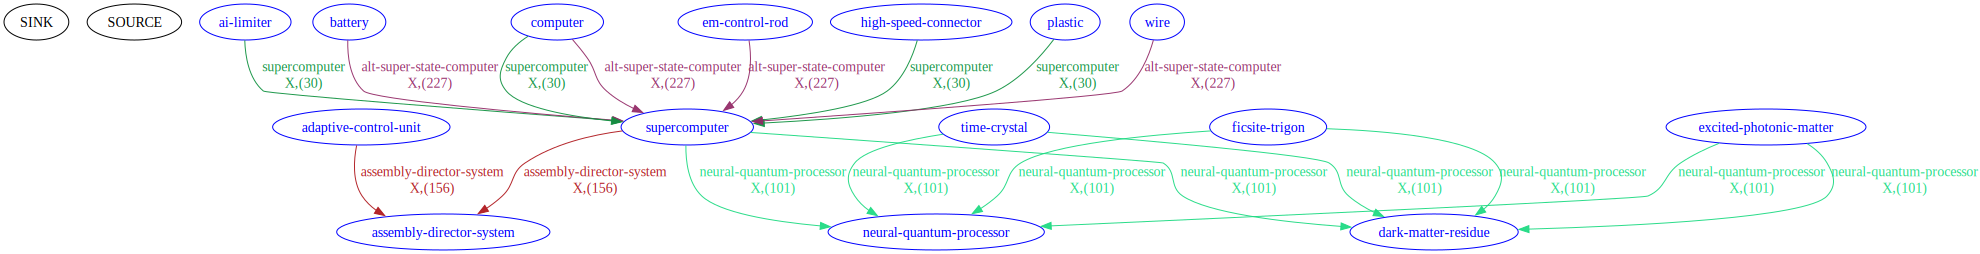

## superposition-oscillator

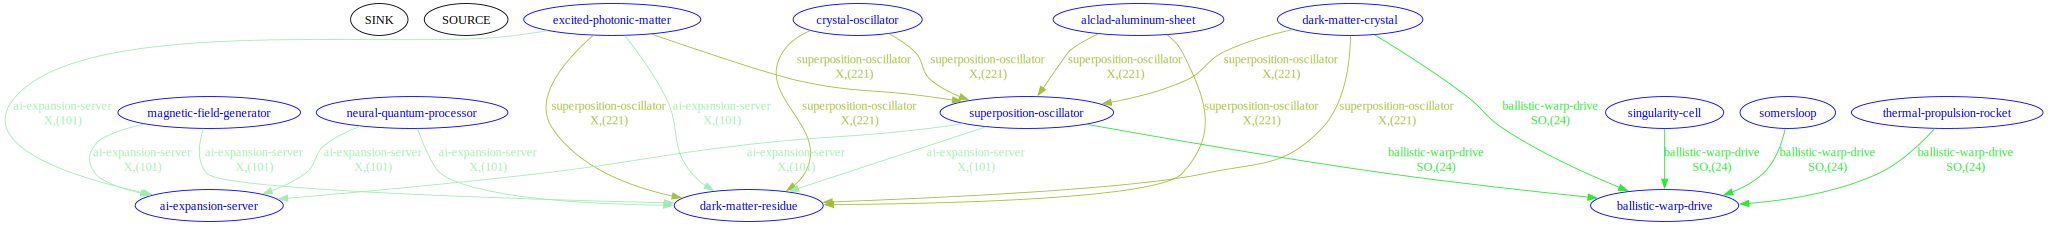

## thermal-propulsion-rocket

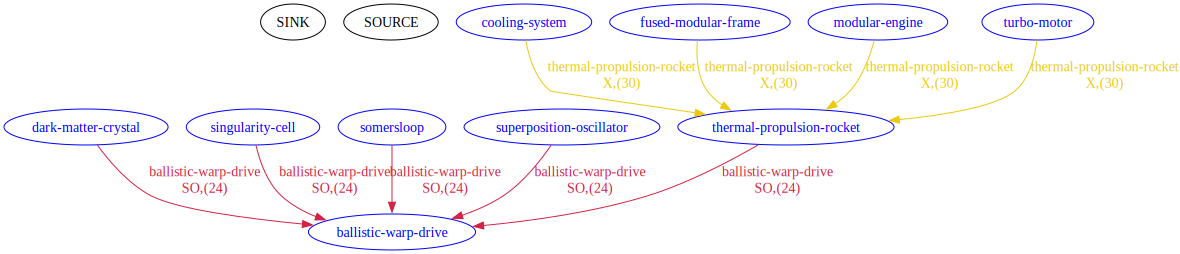

## time-crystal

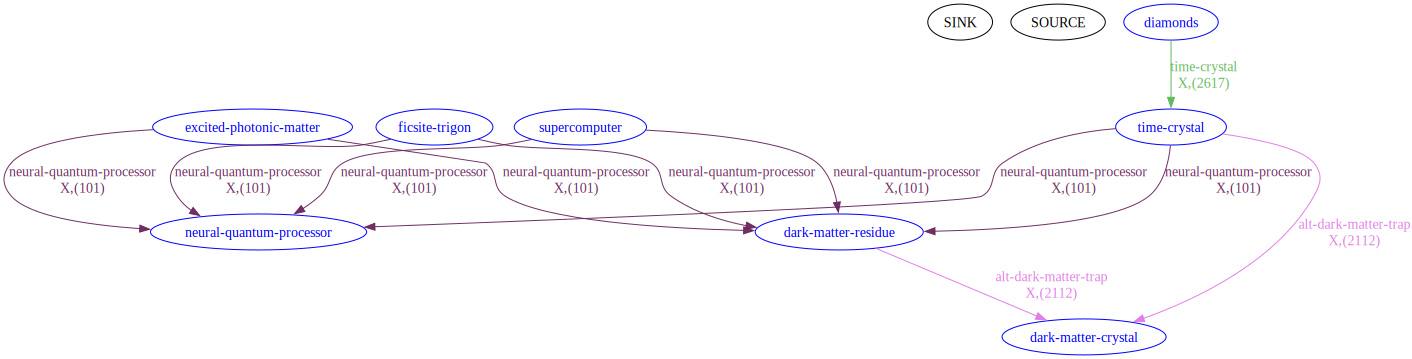

## turbo-motor

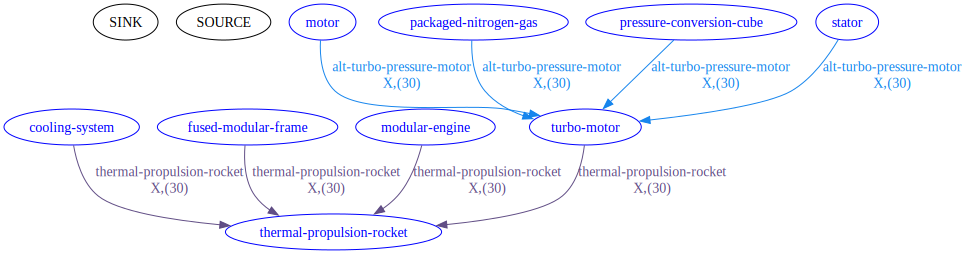

## turbofuel

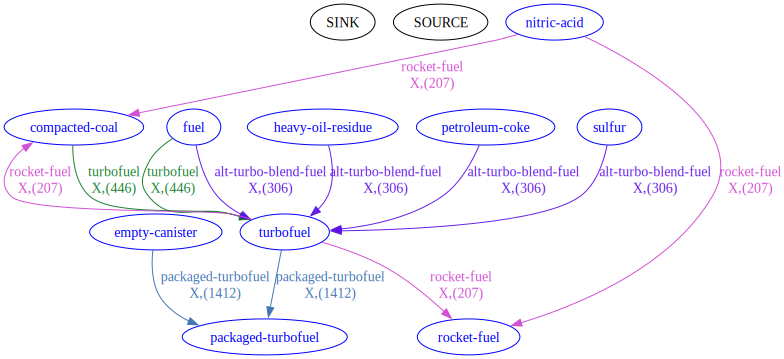

## uranium

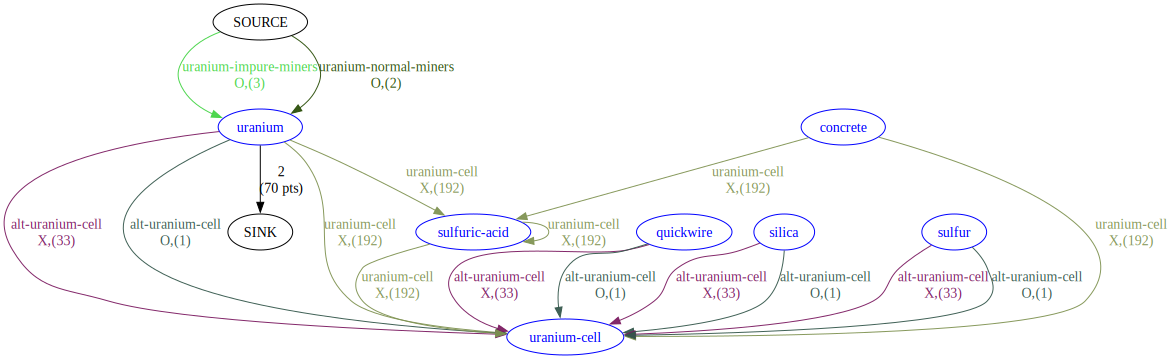

## uranium-cell

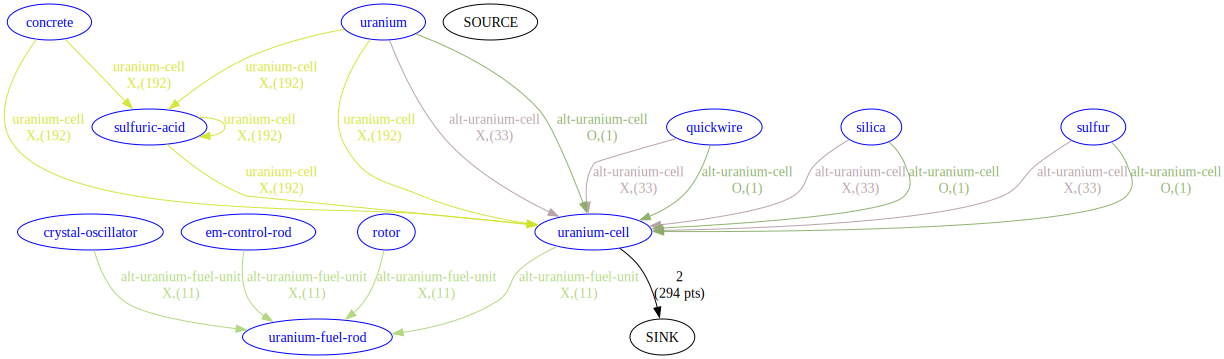

## uranium-fuel-rod

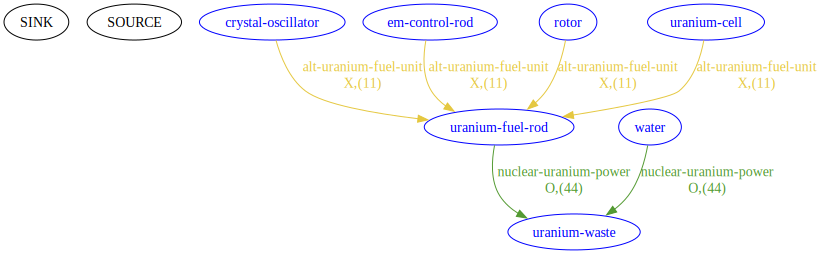

## uranium-waste

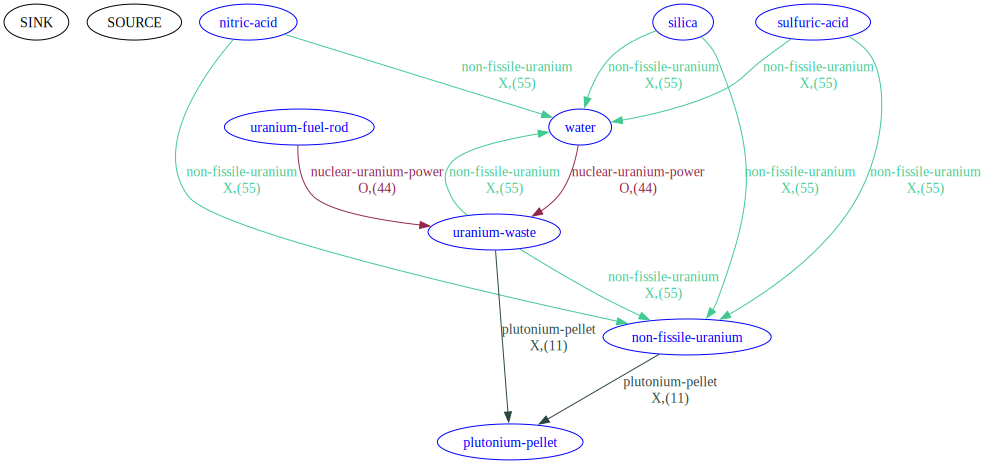

## versatile-framework

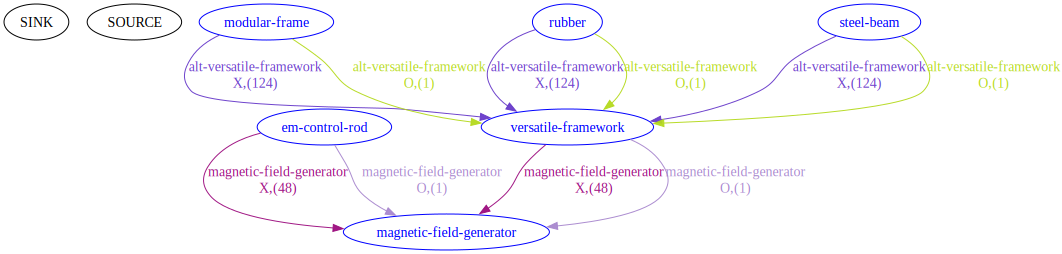

## water

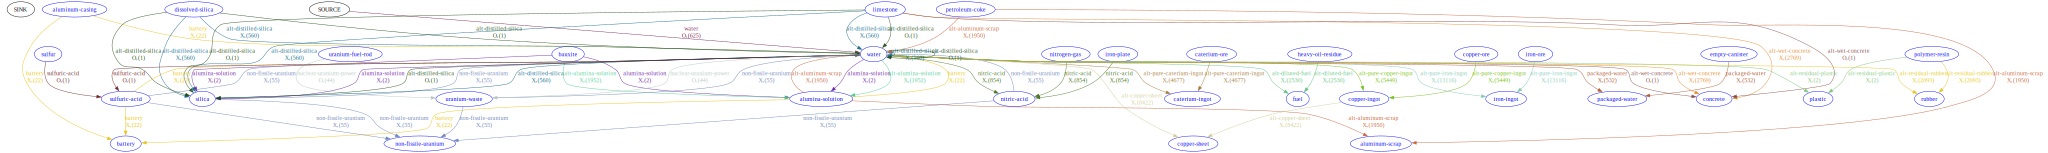

## wire

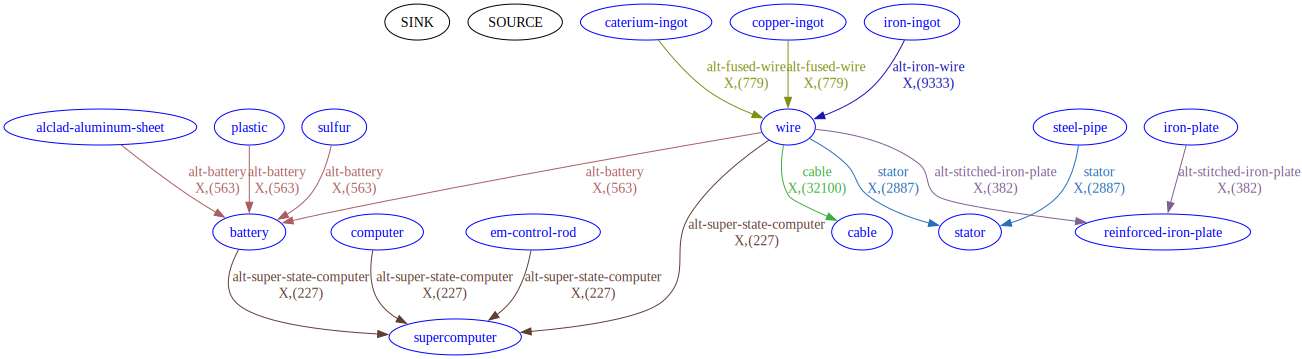

In [103]:
graph_all_individual_items(res_full[1])

In [104]:
# res[1].to_csv('OUTPUT.csv', index=False)